In [1]:
### Set up environment
## Import libraries
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
from xgboost import XGBClassifier
import pickle
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.decomposition import PCA
import harmonypy as hm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/2022_12_07_new_multilin_panel/")

In [2]:
class harmony_knn_tester:
    """

    Class to test integration of two datasets using harmony batch correction and
    KNN classification.

    """
    def __init__(self, df1, df2, anno1, anno2, exp_name="Harmony Experiment", 
            groups_order=None):
        self.data = np.concatenate([df1.values, df2.values])
        self.anno = pd.concat([anno1, anno2])
        self.anno.columns = ["cell", "group"]
        self.anno["assay"] = (["assay_1"] * anno1.shape[0]) + \
            (["assay_2"] * anno2.shape[0])
        self.anno.index = list(range(0, self.anno.shape[0]))
        self.exp_name = exp_name
        if groups_order is None:
            self.groups_order = self.anno["group"].unique()
        else:
            self.groups_order = groups_order

        self.pca = None
        self.pca_embedding = None
        self.n_pc_calc = 50
        self.n_pc_use = 20
        self.harmony = None
        self.harmony_embedding = None
        self.label_encoder = None
        self.knn_classifier = None
        self.assay_2_true = None
        self.assay_2_preds = None
        self.ari = None

    def run_pca(self, **kwargs):
        if "n_components" in kwargs:
            input_n_pc_calc = kwargs["n_components"]
        else:
            input_n_pc_calc = self.n_pc_calc

        self.pca = PCA(n_components=input_n_pc_calc, **kwargs)
        self.pca_embedding = self.pca.fit_transform(self.data)
        plt.close("all")
        plt.plot(\
            list(range(1,input_n_pc_calc+1)),
            self.pca.explained_variance_ratio_)
        plt.title("PC Elbo Curve Check")
        plt.show()

    def run_harmony(self):
        print("Starting harmony...")
        self.harmony = hm.run_harmony(\
            self.pca_embedding[:,:self.n_pc_use],
            self.anno,
            ["assay"])
        self.harmony_embedding = pd.DataFrame(\
            self.harmony.Z_corr.T, 
            index=self.anno.index.values)
        print("Harmony Done!")

    def knn_label_transfer(self):
        print("Starting KNN-label transfer...")
        self.label_encoder = LabelEncoder()
        knn_Y_train_encoded = self.label_encoder.fit_transform(\
            self.anno.loc[self.anno["assay"] == "assay_1", "group"].values)
        self.knn_classifier = KNeighborsClassifier(\
            n_neighbors=15,
            weights='distance')
        self.knn_classifier.fit(\
            self.harmony_embedding.loc[\
                self.anno.loc[\
                    self.anno["assay"] == "assay_1"].index.values].values,
            knn_Y_train_encoded)
        self.assay_2_preds = self.label_encoder.inverse_transform(\
            self.knn_classifier.predict(\
                self.harmony_embedding.loc[\
                    self.anno.loc[\
                        self.anno["assay"] == "assay_2"].index.values].values))
        self.assay_2_true = self.anno.loc[\
            self.anno["assay"] == "assay_2", "group"].values
        print("KNN-label transfer done!")
        
    def obtain_classification_metrics(self):
        self.ari = adjusted_rand_score(\
            self.assay_2_true,
            self.assay_2_preds)
    
    def plot_confusion_matrix(self, path_save_fig=None):
        plt.close("all")
        fig, ax = plt.subplots(figsize=(18,18))

        ax.set_title("{}, ARI Score: {:.4f}".format(self.exp_name, self.ari))

        ConfusionMatrixDisplay.from_predictions(\
            y_true=self.assay_2_true,
            y_pred=self.assay_2_preds,
            labels=self.groups_order,
            xticks_rotation=45,
            ax=ax,
            cmap="coolwarm",
            normalize="true",
            values_format=".2f",
            colorbar=False)

        if path_save_fig == None:
            plt.show()
        else:
            plt.savefig(path_save_fig)
        

In [3]:
order_ari_groups = [\
    "HSCP", "CD127", "preMegE", "MkP", "preCFU-E",
    "CFU-E", "preGM", "Ly6C-1", "Ly6C-2", "Ly6C-3",
    "Ly6C-4", "W", "X", "Y", "Z",
    "IG2", "proNeu1", "proNeu2", "preNeu1", "preNeu2",
    "preNeu3", "immNeu1", "immNeu2"]

order_ari_groups = pd.Series(list(range(1,len(order_ari_groups)+1)),
    index=order_ari_groups)

order_ari_groups

HSCP         1
CD127        2
preMegE      3
MkP          4
preCFU-E     5
CFU-E        6
preGM        7
Ly6C-1       8
Ly6C-2       9
Ly6C-3      10
Ly6C-4      11
W           12
X           13
Y           14
Z           15
IG2         16
proNeu1     17
proNeu2     18
preNeu1     19
preNeu2     20
preNeu3     21
immNeu1     22
immNeu2     23
dtype: int64

In [15]:
path_cite = "output/cite_inflow_integration_input/without_adt_umi_filtering/"\
    "mapped_cite_ari_adt_alone_all_cells.fea"
path_flow = "output/cite_inflow_integration_input/gated_inflow_inputs/"\
    "inflow_gated_1k_each_ari_groups_adt_alone.fea"

# Read in the data
cite = pd.read_feather(path_cite).set_index("index")
cite





,ADT_Link-0:CCR3_CD193:CD193,ADT_Link-1:CD102:CD102,ADT_Link-2:CD105:BUV805-A,ADT_Link-3:CD106:PerCP-Cy5.5-A,ADT_Link-4:CD107a_LAMP_1:CD107a,ADT_Link-5:CD117_c_kit:BV650-A,ADT_Link-6:CD11a:CD11a,ADT_Link-7:CD11c:CD11c,ADT_Link-8:CD127:BV785-A,ADT_Link-9:CD135:PE-Cy5-A,...,ADT_Link-97:anti_human_mouse_CD49f:CD49f,ADT_Link-98:anti_human_mouse_integrin_7:BUV615-A,ADT_Link-99:anti_mouse_human_CD11b:BV750-A,ADT_Link-100:anti_mouse_human_CD44:CD44,ADT_Link-102:anti_mouse_rat_CD29:CD29,ADT_Link-103:anti_mouse_rat_CD61:CD61,ADT_Link-104:anti_mouse_rat_CD81:CD81,ADT_Link-105:anti_mouse_rat_human_CD27:BUV737-A,ADT_Link-203:CD49d:LPAM1,ADT_Link-204:anti_human_mouse_integrin_7:LPAM1
index,,,,,,,,,,,,,,,,,,,,,
GACGCTGGTACCTGTA-1.AS_CITE_HSC,0.109053,0.291741,0.094863,0.404280,0.298199,0.176327,0.368332,0.223758,0.271628,0.162636,...,0.442887,0.107392,0.153413,0.508200,0.440553,0.199158,0.499944,0.731139,0.044956,0.135195
AACCCAAAGGTAGACC-1.AS_CITE_HSC,0.128139,0.214157,0.109731,0.409287,0.322791,0.149756,0.259854,0.224522,0.256019,0.176585,...,0.308497,0.099949,0.118945,0.407444,0.212036,0.151391,0.424361,0.529137,0.037117,0.114518
CGACAGCCACGCAGTC-1.AS_CITE_HSC,0.143296,0.232997,0.122120,0.420214,0.177241,0.181558,0.268982,0.225052,0.340398,0.174360,...,0.381414,0.102328,0.139500,0.345777,0.302912,0.212069,0.460541,0.434687,0.042773,0.120808
TGCGGCAAGGCTGTAG-1.AS_CITE_HSC,0.123056,0.212693,0.107196,0.409320,0.285386,0.147816,0.276562,0.223849,0.298795,0.171461,...,0.283883,0.116601,0.123034,0.319057,0.217880,0.170351,0.404469,0.416065,0.036406,0.162222
TTGTTTGTCCGTGGTG-1.AS_CITE_HSC,0.083344,0.213089,0.068175,0.395780,0.395171,0.105887,0.308653,0.222661,0.152590,0.123011,...,0.312402,0.112037,0.163248,0.373460,0.251743,0.198909,0.500328,0.272224,0.031137,0.148246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGCATCAGTTAAGCAA-1.AS_CITE_Kit,0.715176,0.314200,0.523877,0.725765,0.782673,0.667552,0.775769,0.232025,0.496817,0.779229,...,0.448765,0.176594,0.802939,0.834934,0.564509,0.765918,0.815128,0.303363,0.245249,0.322438
TCGAAGTAGACATCAA-1.AS_CITE_Multilin1,0.588441,0.272053,0.292786,0.485694,0.519889,0.312174,0.779576,0.231220,0.306701,0.373748,...,0.344851,0.139838,0.832968,0.847900,0.389816,0.779167,0.583182,0.293134,0.127877,0.241422
CCTCCAACATAAGCAA-1.AS_CITE_Multilin1,0.606077,0.282908,0.318720,0.494038,0.580614,0.357147,0.784331,0.231508,0.349271,0.640178,...,0.400379,0.144603,0.850696,0.852793,0.443085,0.790215,0.605224,0.247991,0.146986,0.255550


In [16]:
cite_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "without_adt_umi_filtering/cell_anno_cite_ari_all_cells.csv")
cite_anno

,cell,umi_adt,port,cluster,ari_group
0,GACGCTGGTACCTGTA-1.AS_CITE_HSC,501,AS_CITE_HSC,ST-HSC,HSCP
1,AACCCAAAGGTAGACC-1.AS_CITE_HSC,501,AS_CITE_HSC,MPP5-Egr1,HSCP
2,CGACAGCCACGCAGTC-1.AS_CITE_HSC,506,AS_CITE_HSC,ST-HSC,HSCP
3,TGCGGCAAGGCTGTAG-1.AS_CITE_HSC,506,AS_CITE_HSC,MPP5-Egr1,HSCP
4,TTGTTTGTCCGTGGTG-1.AS_CITE_HSC,508,AS_CITE_HSC,LT-HSC_Mllt3,HSCP
...,...,...,...,...,...
22833,AGCATCAGTTAAGCAA-1.AS_CITE_Kit,1697,AS_CITE_Kit,immNeu-2,immNeu2
22834,TCGAAGTAGACATCAA-1.AS_CITE_Multilin1,1699,AS_CITE_Multilin1,immNeu-3,immNeu2
22835,CCTCCAACATAAGCAA-1.AS_CITE_Multilin1,1727,AS_CITE_Multilin1,immNeu-2,immNeu2
22836,TTCATGTGTACCGCGT-1.AS_CITE_Kit,1728,AS_CITE_Kit,immNeu-3,immNeu2


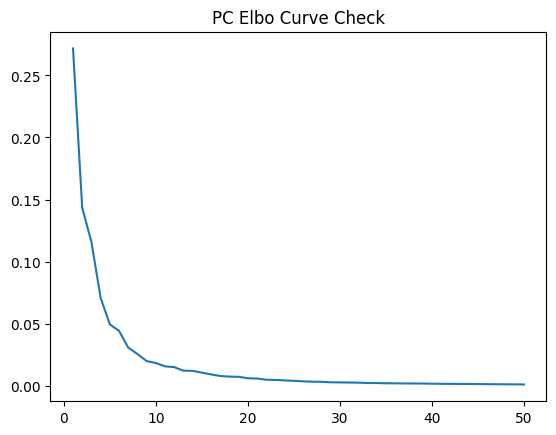

2023-01-28 17:09:02,575 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Starting harmony...


2023-01-28 17:09:09,175 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-01-28 17:09:09,480 - harmonypy - INFO - Iteration 1 of 10
2023-01-28 17:09:29,731 - harmonypy - INFO - Iteration 2 of 10
2023-01-28 17:09:50,109 - harmonypy - INFO - Iteration 3 of 10
2023-01-28 17:10:10,375 - harmonypy - INFO - Iteration 4 of 10
2023-01-28 17:10:30,677 - harmonypy - INFO - Iteration 5 of 10
2023-01-28 17:10:51,172 - harmonypy - INFO - Iteration 6 of 10
2023-01-28 17:11:11,629 - harmonypy - INFO - Iteration 7 of 10
2023-01-28 17:11:32,053 - harmonypy - INFO - Iteration 8 of 10
2023-01-28 17:11:52,321 - harmonypy - INFO - Iteration 9 of 10
2023-01-28 17:12:12,754 - harmonypy - INFO - Iteration 10 of 10
2023-01-28 17:12:32,929 - harmonypy - INFO - Stopped before convergence


Harmony Done!
Starting KNN-label transfer...
KNN-label transfer done!


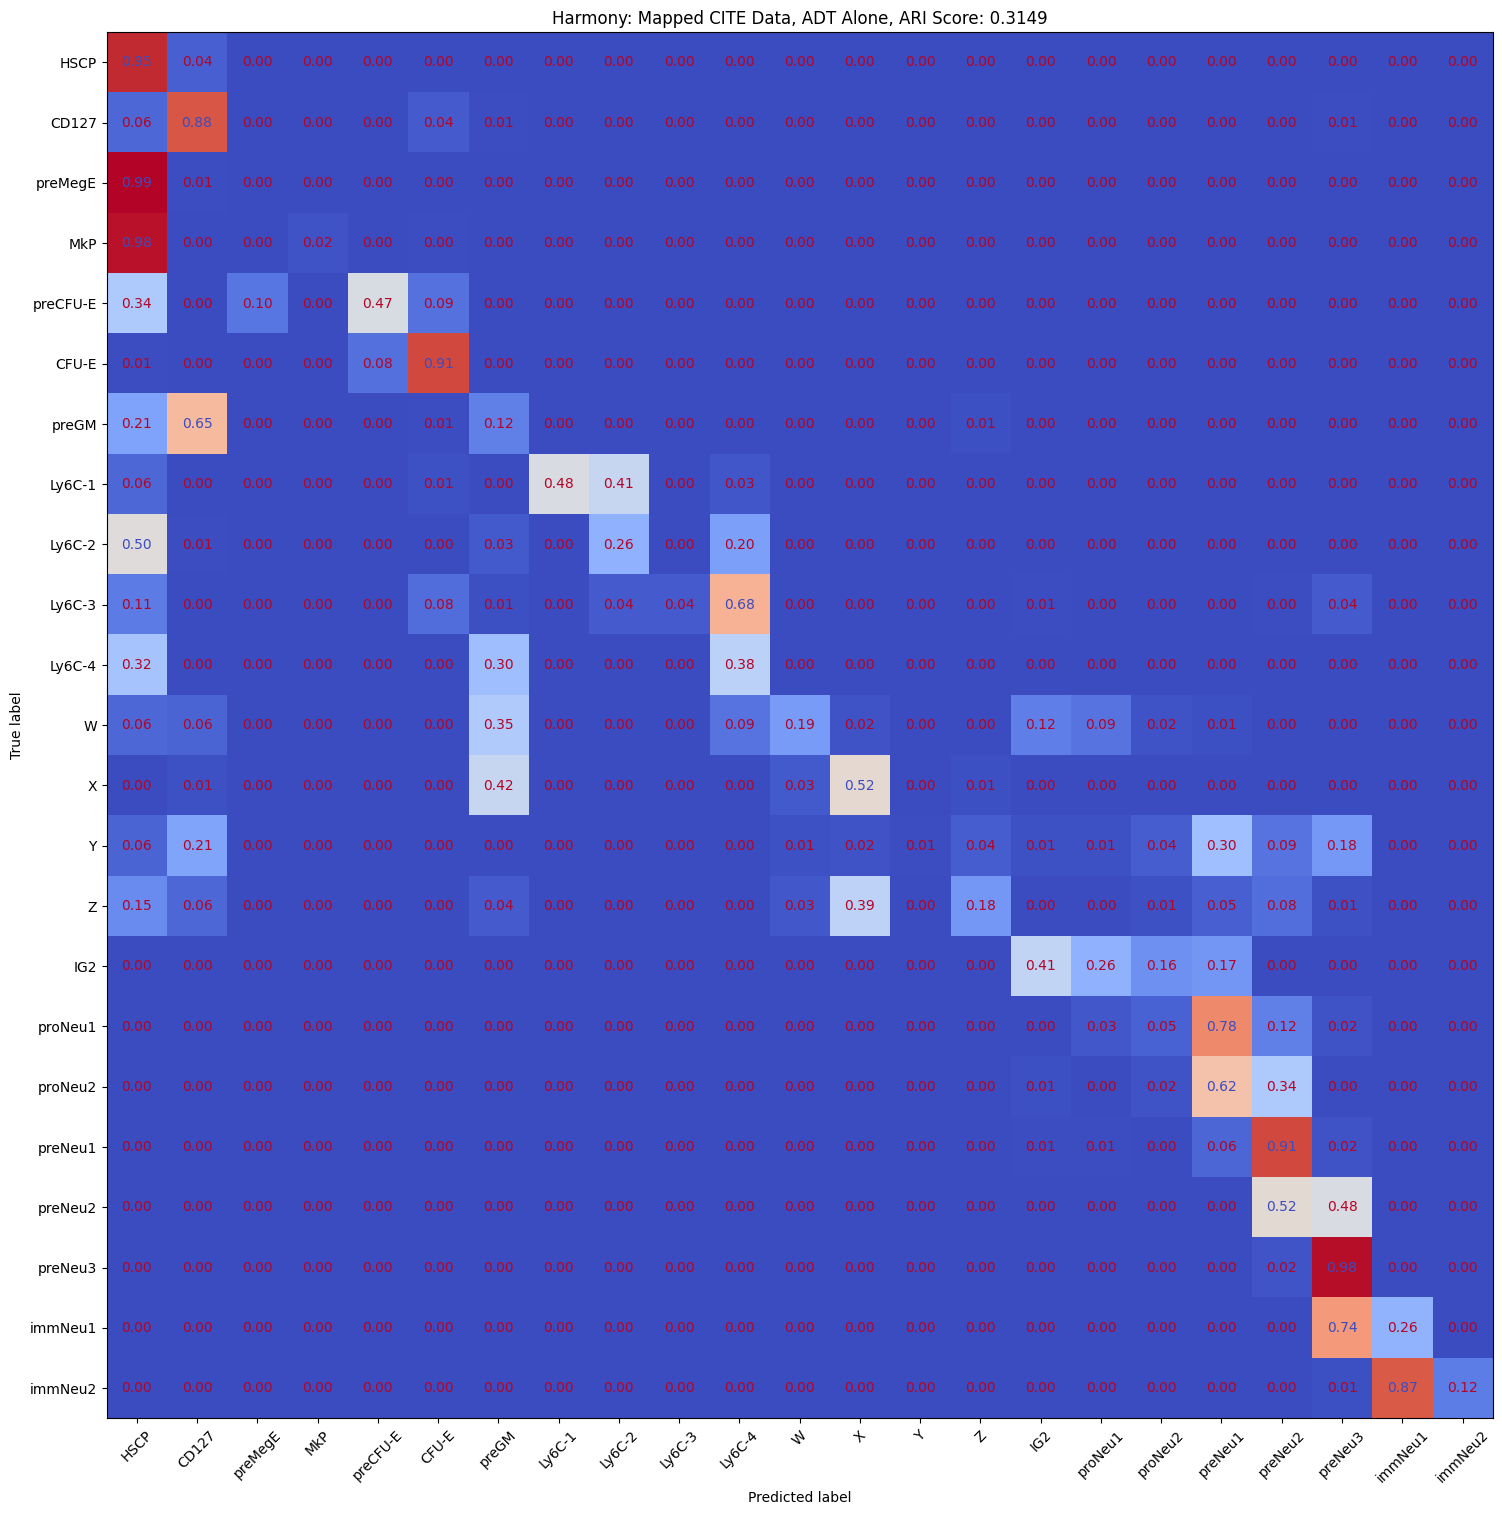

In [4]:
# Mapped CITE-seq ADT alone
path_cite = "output/cite_inflow_integration_input/without_adt_umi_filtering/"\
    "mapped_cite_ari_adt_alone_all_cells.fea"
path_flow = "output/cite_inflow_integration_input/gated_inflow_inputs/"\
    "inflow_gated_1k_each_ari_groups_adt_alone.fea"

# Read in the data
cite = pd.read_feather(path_cite).set_index("index")
flow = pd.read_feather(path_flow)

# Read the annotation
cite_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "without_adt_umi_filtering/cell_anno_cite_ari_all_cells.csv")
flow_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "gated_inflow_inputs/inflow_gated_1k_each_ari_groups_adt_alone_groups.csv", 
    header=None)

# Set up the annotation to fig class input
tmp_anno_1 = cite_anno[["cell", "ari_group"]]
tmp_anno_1.columns = ["cell", "group"]
tmp_anno_2 = flow_anno
tmp_anno_2.columns = ["cell", "group"]

# Make Harmony tester object
mapped_cite_adt_alone_all = harmony_knn_tester(\
    df1=cite,
    df2=flow[cite.columns.values],
    anno1=tmp_anno_1,
    anno2=tmp_anno_2,
    exp_name="Harmony: Mapped CITE Data, ADT Alone",
    groups_order=order_ari_groups.index.values)

# Run steps of harmony integration
mapped_cite_adt_alone_all.run_pca()
mapped_cite_adt_alone_all.run_harmony()
mapped_cite_adt_alone_all.knn_label_transfer()
mapped_cite_adt_alone_all.obtain_classification_metrics()
mapped_cite_adt_alone_all.plot_confusion_matrix(\
    path_save_fig="output/harmony_1k_per_gate_tests/"\
        "harmony_mapped_cite_adt_alone_conf_mat.png")


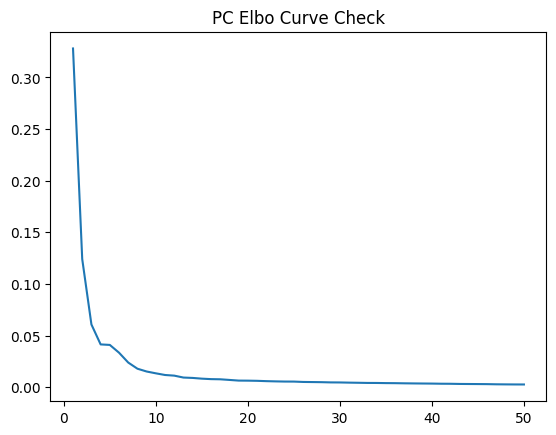

2023-01-28 17:12:37,939 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Starting harmony...


2023-01-28 17:12:43,748 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-01-28 17:12:44,055 - harmonypy - INFO - Iteration 1 of 10
2023-01-28 17:13:04,956 - harmonypy - INFO - Iteration 2 of 10
2023-01-28 17:13:25,452 - harmonypy - INFO - Iteration 3 of 10
2023-01-28 17:13:45,703 - harmonypy - INFO - Converged after 3 iterations


Harmony Done!
Starting KNN-label transfer...
KNN-label transfer done!


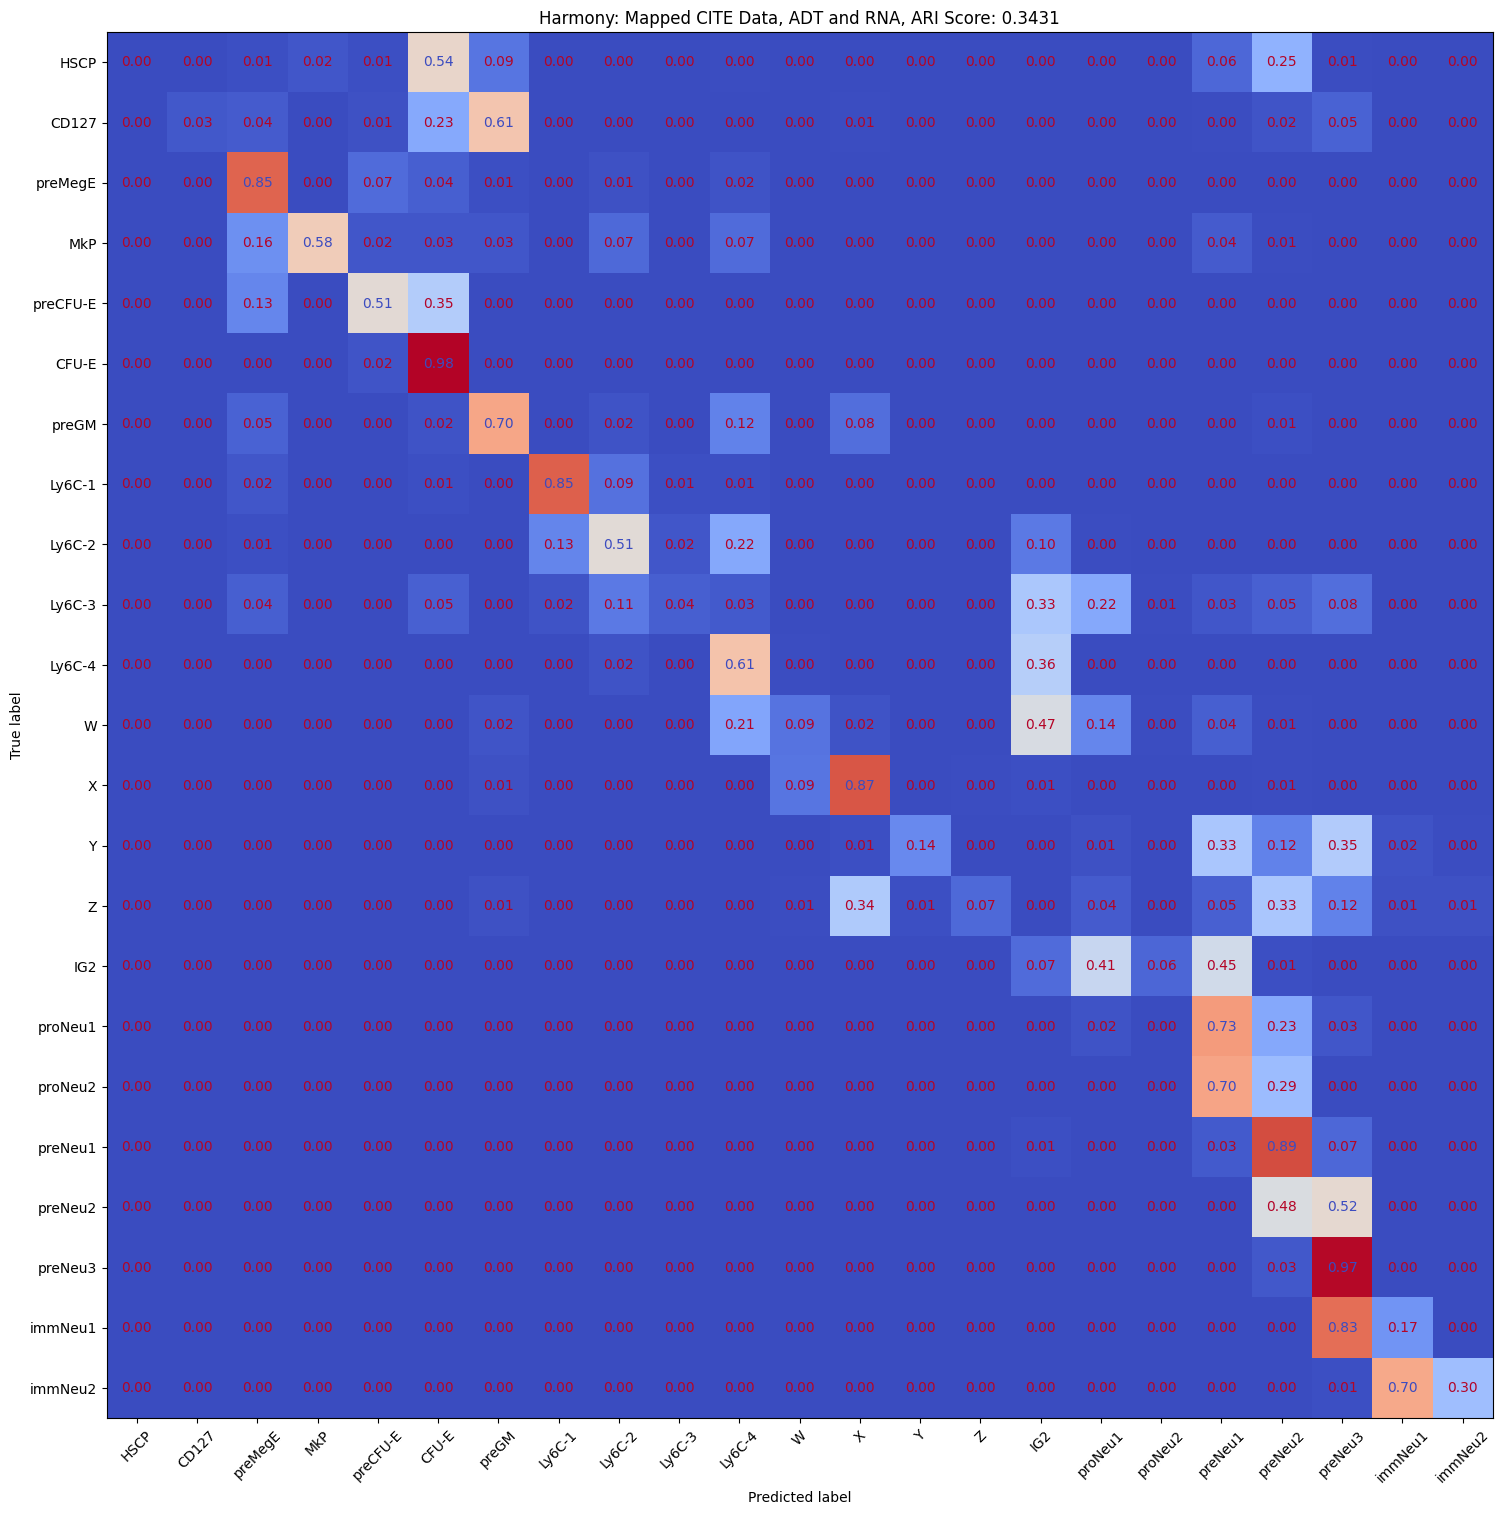

In [5]:
# Mapped CITE-seq ADT and RNA
path_cite = "output/cite_inflow_integration_input/without_adt_umi_filtering/"\
    "mapped_cite_ari_adt_rna_all_cells.fea"
path_flow = "output/cite_inflow_integration_input/gated_inflow_inputs/"\
    "inflow_gated_1k_each_ari_groups_adt_rna.fea"

# Read in the data
cite = pd.read_feather(path_cite).set_index("index")
flow = pd.read_feather(path_flow)

# Read the annotation
cite_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "without_adt_umi_filtering/cell_anno_cite_ari_all_cells.csv")
flow_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "gated_inflow_inputs/inflow_gated_1k_each_ari_groups_adt_alone_groups.csv", 
    header=None)

# Set up the annotation to fig class input
tmp_anno_1 = cite_anno[["cell", "ari_group"]]
tmp_anno_1.columns = ["cell", "group"]
tmp_anno_2 = flow_anno
tmp_anno_2.columns = ["cell", "group"]

# Make Harmony tester object
mapped_cite_adt_rna_all = harmony_knn_tester(\
    df1=cite,
    df2=flow[cite.columns.values],
    anno1=tmp_anno_1,
    anno2=tmp_anno_2,
    exp_name="Harmony: Mapped CITE Data, ADT and RNA",
    groups_order=order_ari_groups.index.values)

# Run steps of harmony integration
mapped_cite_adt_rna_all.run_pca()
mapped_cite_adt_rna_all.run_harmony()
mapped_cite_adt_rna_all.knn_label_transfer()
mapped_cite_adt_rna_all.obtain_classification_metrics()
mapped_cite_adt_rna_all.plot_confusion_matrix(\
    path_save_fig="output/harmony_1k_per_gate_tests/"\
        "harmony_mapped_cite_adt_rna_conf_mat.png")

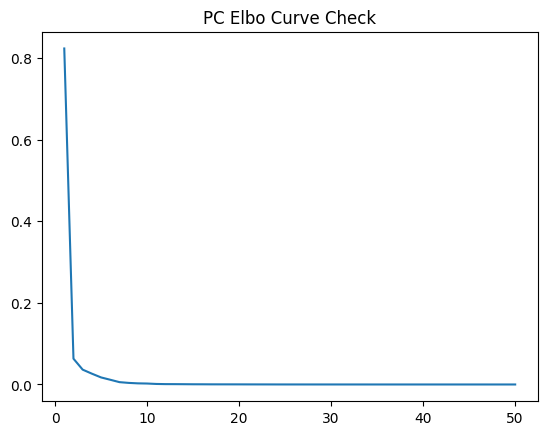

2023-01-28 18:43:32,462 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Starting harmony...


2023-01-28 18:43:39,970 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-01-28 18:43:40,274 - harmonypy - INFO - Iteration 1 of 10
2023-01-28 18:44:02,650 - harmonypy - INFO - Iteration 2 of 10
2023-01-28 18:44:23,772 - harmonypy - INFO - Iteration 3 of 10
2023-01-28 18:44:45,233 - harmonypy - INFO - Iteration 4 of 10
2023-01-28 18:45:06,670 - harmonypy - INFO - Iteration 5 of 10
2023-01-28 18:45:19,847 - harmonypy - INFO - Iteration 6 of 10
2023-01-28 18:45:26,013 - harmonypy - INFO - Iteration 7 of 10
2023-01-28 18:45:32,120 - harmonypy - INFO - Converged after 7 iterations


Harmony Done!
Starting KNN-label transfer...
KNN-label transfer done!


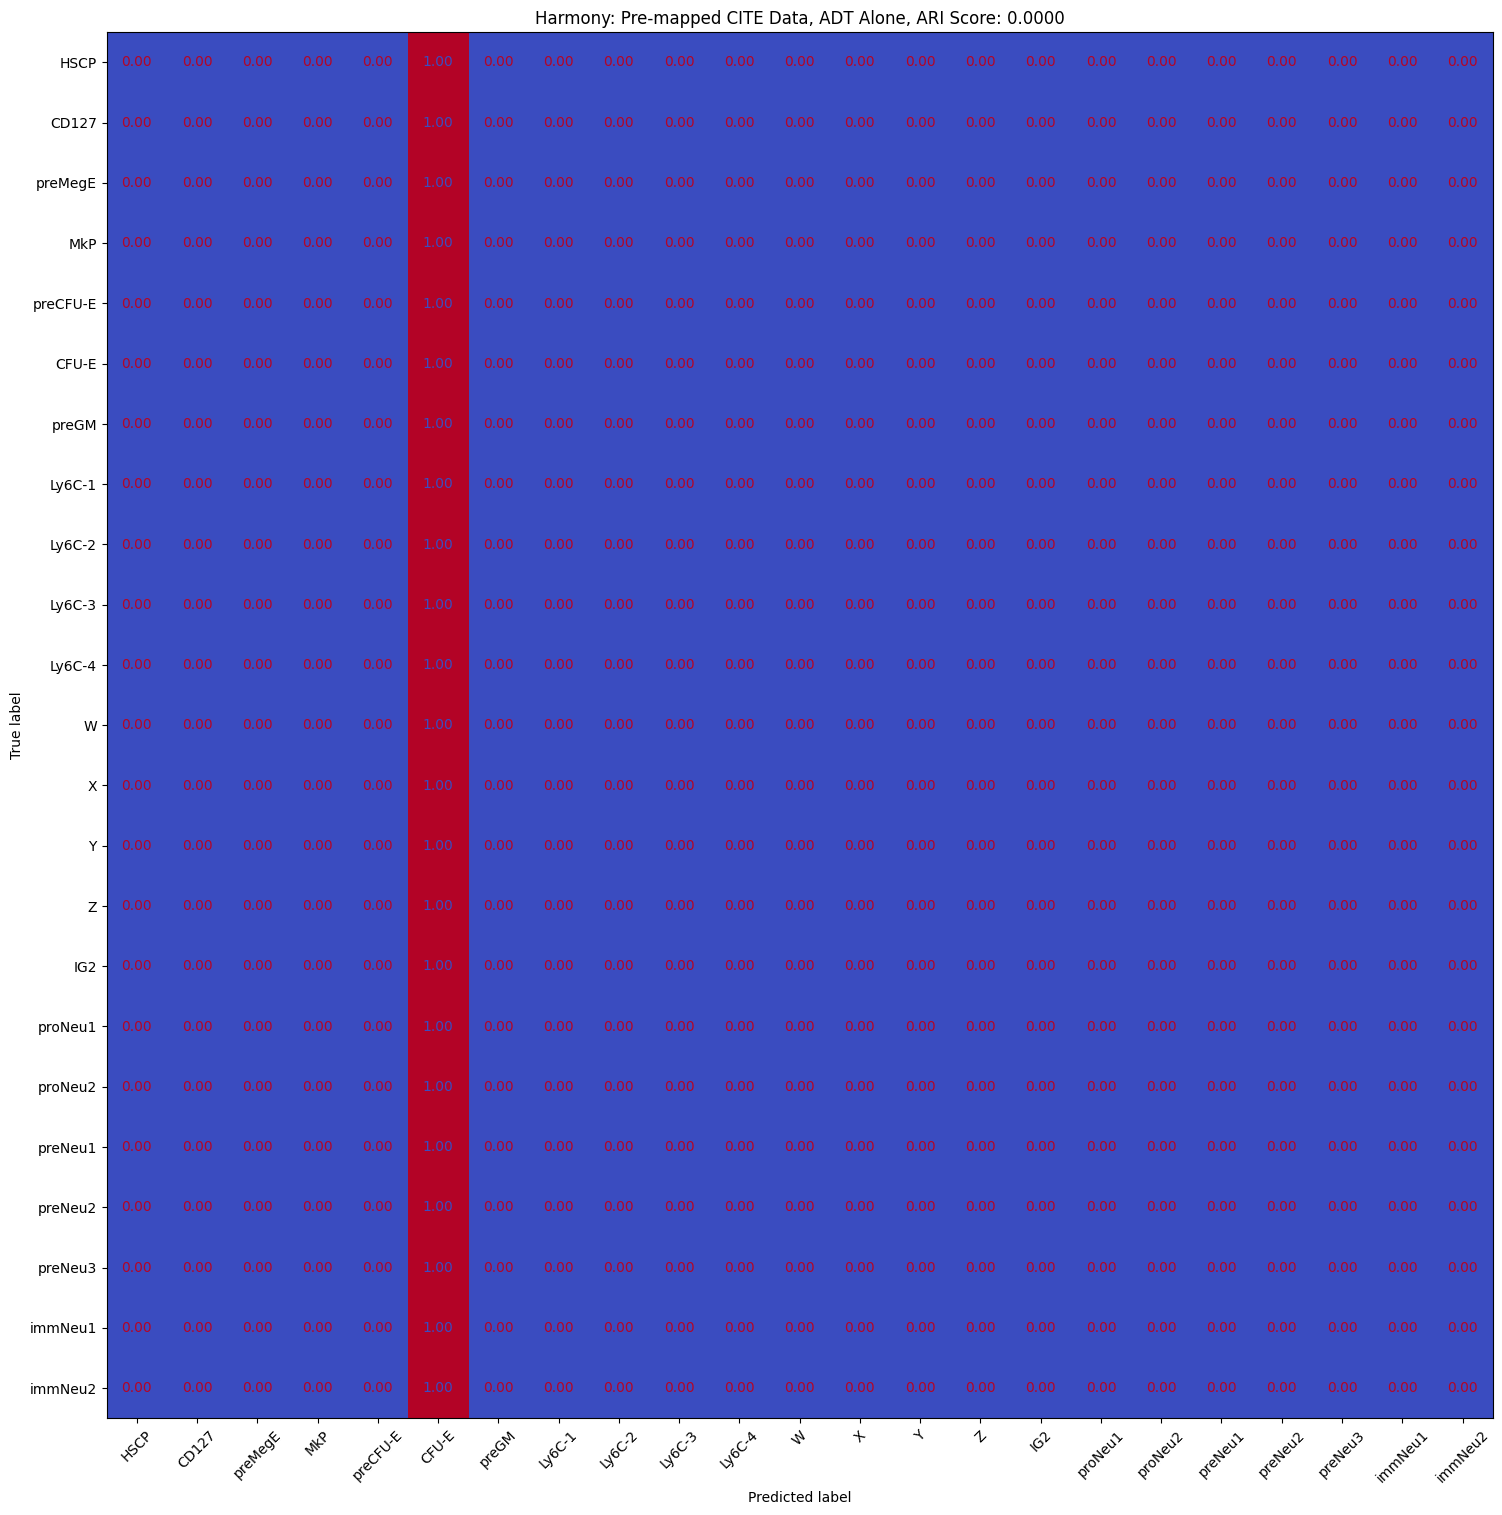

In [7]:
# Pre-mapped CITE-seq ADT Alone
path_cite = "output/cite_inflow_integration_input/without_adt_umi_filtering/"\
    "pre_mapped_cite_ari_adt_alone_all_cells.fea"
path_flow = "output/cite_inflow_integration_input/gated_inflow_inputs/"\
    "inflow_gated_1k_each_ari_groups_adt_alone.fea"

# Read in the data
cite = pd.read_feather(path_cite).rename({"final": "index"}, axis=1).set_index("index")
flow = pd.read_feather(path_flow)

# Read the annotation
cite_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "without_adt_umi_filtering/cell_anno_cite_ari_all_cells.csv")
flow_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "gated_inflow_inputs/inflow_gated_1k_each_ari_groups_adt_alone_groups.csv", 
    header=None)

# Set up the annotation to fig class input
tmp_anno_1 = cite_anno[["cell", "ari_group"]]
tmp_anno_1.columns = ["cell", "group"]
tmp_anno_2 = flow_anno
tmp_anno_2.columns = ["cell", "group"]

# Make Harmony tester object
pre_mapped_cite_adt_alone_all = harmony_knn_tester(\
    df1=cite,
    df2=flow[cite.columns.values],
    anno1=tmp_anno_1,
    anno2=tmp_anno_2,
    exp_name="Harmony: Pre-mapped CITE Data, ADT Alone",
    groups_order=order_ari_groups.index.values)

# Run steps of harmony integration
pre_mapped_cite_adt_alone_all.run_pca()
pre_mapped_cite_adt_alone_all.run_harmony()
pre_mapped_cite_adt_alone_all.knn_label_transfer()
pre_mapped_cite_adt_alone_all.obtain_classification_metrics()
pre_mapped_cite_adt_alone_all.plot_confusion_matrix(\
    path_save_fig="output/harmony_1k_per_gate_tests/"\
        "harmony_pre_mapped_cite_adt_alone_conf_mat.png")

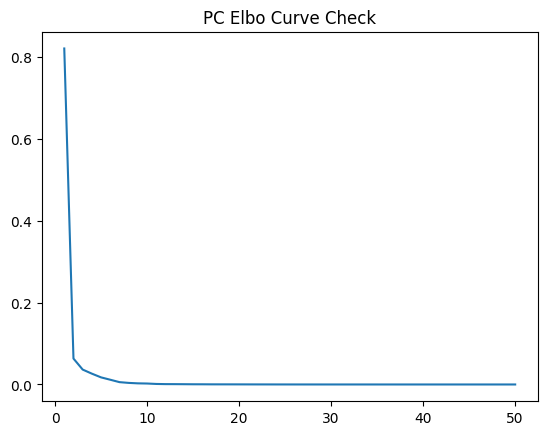

2023-01-28 20:48:30,232 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Starting harmony...


2023-01-28 20:48:37,824 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-01-28 20:48:38,135 - harmonypy - INFO - Iteration 1 of 10
2023-01-28 20:48:58,486 - harmonypy - INFO - Iteration 2 of 10
2023-01-28 20:49:18,949 - harmonypy - INFO - Iteration 3 of 10
2023-01-28 20:49:39,553 - harmonypy - INFO - Iteration 4 of 10
2023-01-28 20:49:59,864 - harmonypy - INFO - Iteration 5 of 10
2023-01-28 20:50:19,750 - harmonypy - INFO - Iteration 6 of 10
2023-01-28 20:50:28,386 - harmonypy - INFO - Iteration 7 of 10
2023-01-28 20:50:34,169 - harmonypy - INFO - Iteration 8 of 10
2023-01-28 20:50:39,933 - harmonypy - INFO - Converged after 8 iterations


Harmony Done!
Starting KNN-label transfer...
KNN-label transfer done!


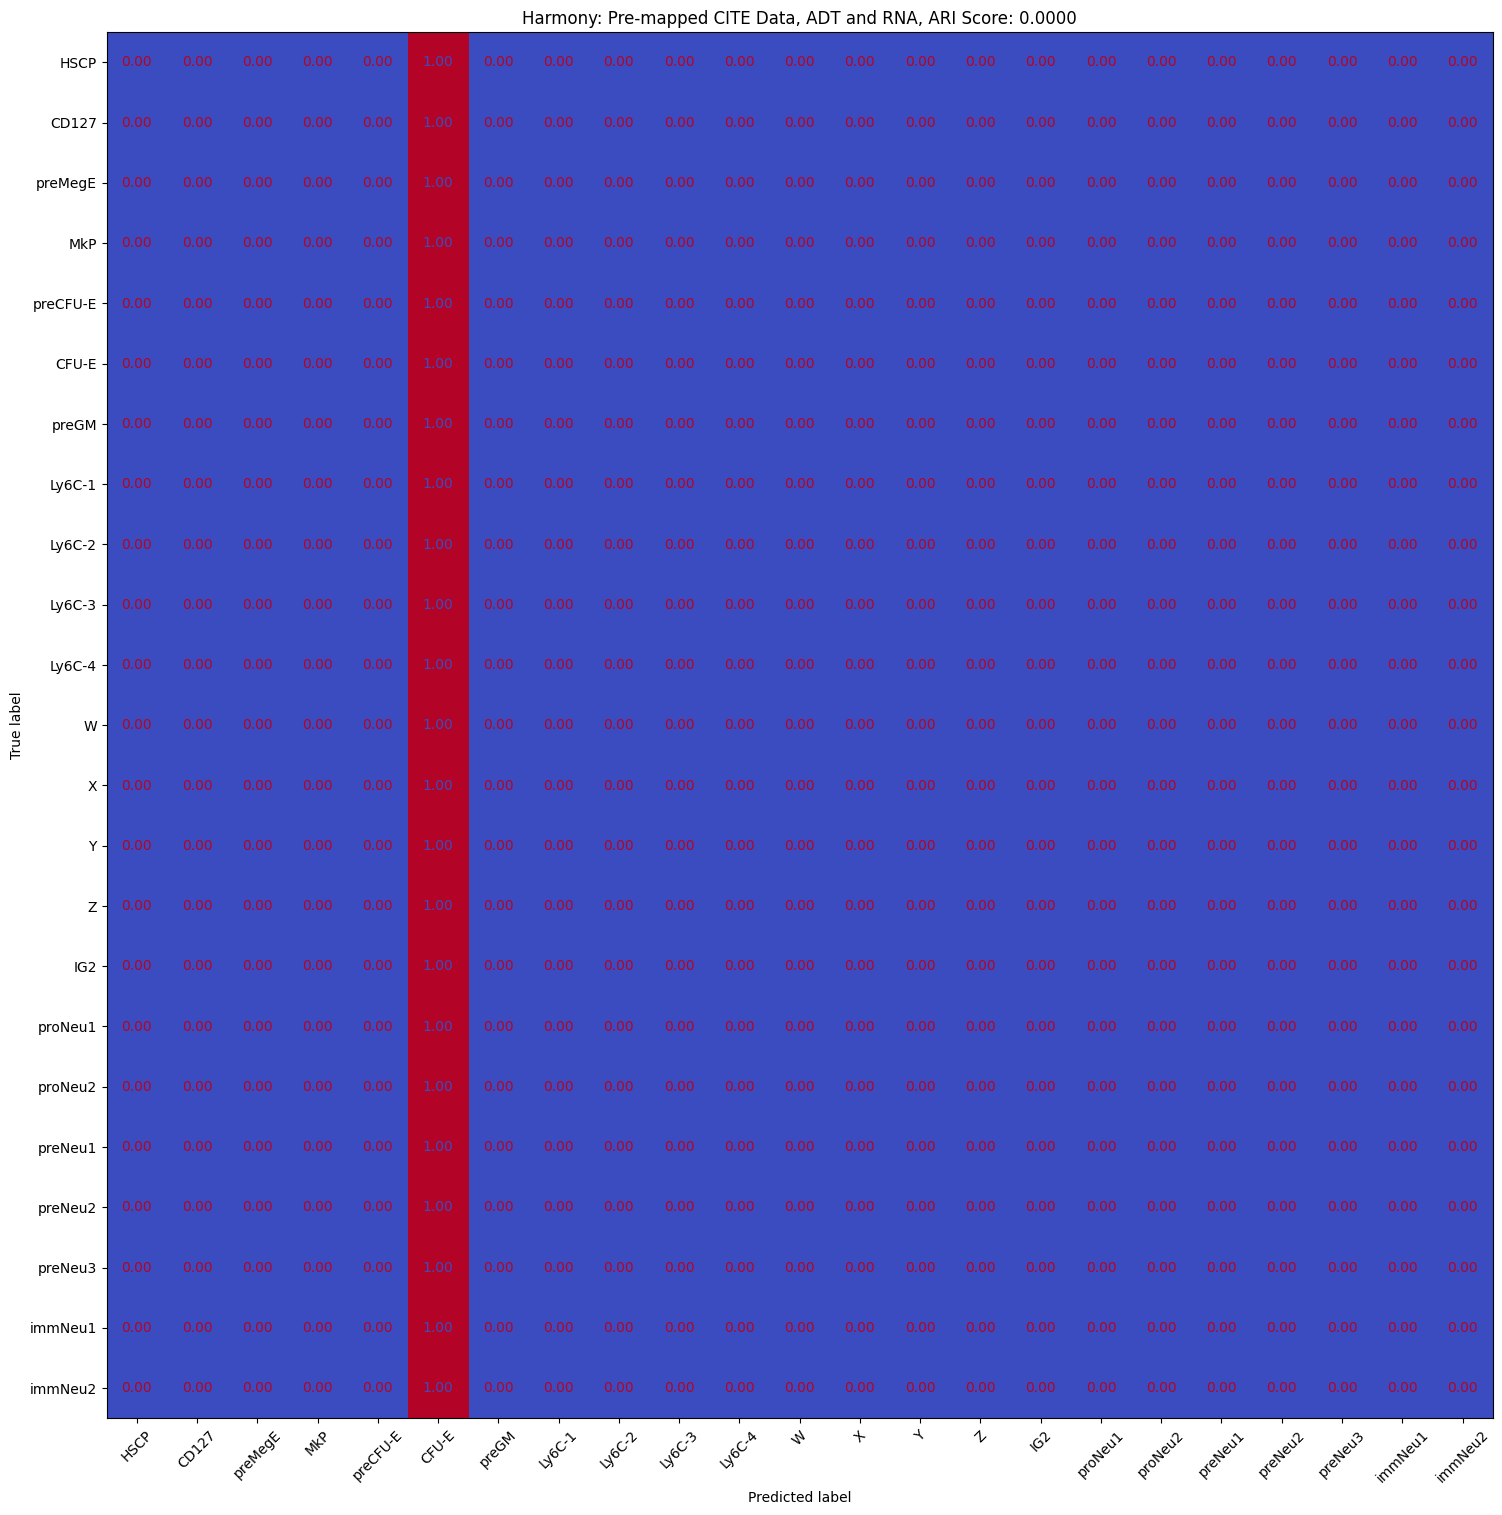

In [9]:
# Pre-mapped CITE-seq ADT and RNA
path_cite = "output/cite_inflow_integration_input/without_adt_umi_filtering/"\
    "pre_mapped_cite_ari_adt_rna_all_cells.fea"
path_flow = "output/cite_inflow_integration_input/gated_inflow_inputs/"\
    "inflow_gated_1k_each_ari_groups_adt_rna.fea"

# Read in the data
cite = pd.read_feather(path_cite).rename({"final": "index"}, axis=1).set_index("index")
flow = pd.read_feather(path_flow)

# Read the annotation
cite_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "without_adt_umi_filtering/cell_anno_cite_ari_all_cells.csv")
flow_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "gated_inflow_inputs/inflow_gated_1k_each_ari_groups_adt_alone_groups.csv", 
    header=None)

# Set up the annotation to fig class input
tmp_anno_1 = cite_anno[["cell", "ari_group"]]
tmp_anno_1.columns = ["cell", "group"]
tmp_anno_2 = flow_anno
tmp_anno_2.columns = ["cell", "group"]

# Make Harmony tester object
pre_mapped_cite_adt_rna_all = harmony_knn_tester(\
    df1=cite,
    df2=flow[cite.columns.values],
    anno1=tmp_anno_1,
    anno2=tmp_anno_2,
    exp_name="Harmony: Pre-mapped CITE Data, ADT and RNA",
    groups_order=order_ari_groups.index.values)

# Run steps of harmony integration
pre_mapped_cite_adt_rna_all.run_pca()
pre_mapped_cite_adt_rna_all.run_harmony()
pre_mapped_cite_adt_rna_all.knn_label_transfer()
pre_mapped_cite_adt_rna_all.obtain_classification_metrics()
pre_mapped_cite_adt_rna_all.plot_confusion_matrix(\
    path_save_fig="output/harmony_1k_per_gate_tests/"\
        "harmony_pre_mapped_cite_adt_rna_conf_mat.png")

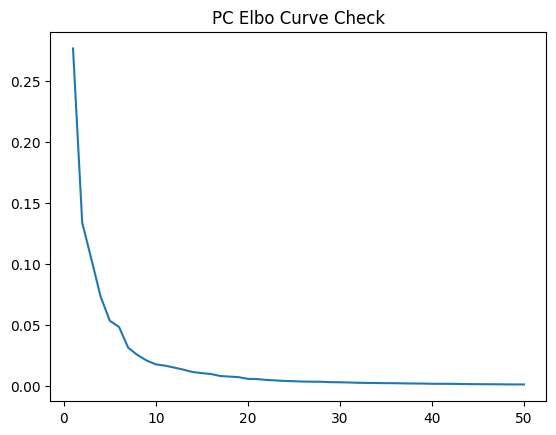

2023-01-28 20:50:43,756 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Starting harmony...


2023-01-28 20:50:48,752 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-01-28 20:50:48,989 - harmonypy - INFO - Iteration 1 of 10
2023-01-28 20:51:04,045 - harmonypy - INFO - Iteration 2 of 10
2023-01-28 20:51:19,525 - harmonypy - INFO - Iteration 3 of 10
2023-01-28 20:51:34,158 - harmonypy - INFO - Iteration 4 of 10
2023-01-28 20:51:49,691 - harmonypy - INFO - Iteration 5 of 10
2023-01-28 20:52:05,298 - harmonypy - INFO - Iteration 6 of 10
2023-01-28 20:52:20,975 - harmonypy - INFO - Iteration 7 of 10
2023-01-28 20:52:36,476 - harmonypy - INFO - Iteration 8 of 10
2023-01-28 20:52:52,024 - harmonypy - INFO - Iteration 9 of 10
2023-01-28 20:53:07,125 - harmonypy - INFO - Iteration 10 of 10
2023-01-28 20:53:23,487 - harmonypy - INFO - Stopped before convergence


Harmony Done!
Starting KNN-label transfer...
KNN-label transfer done!


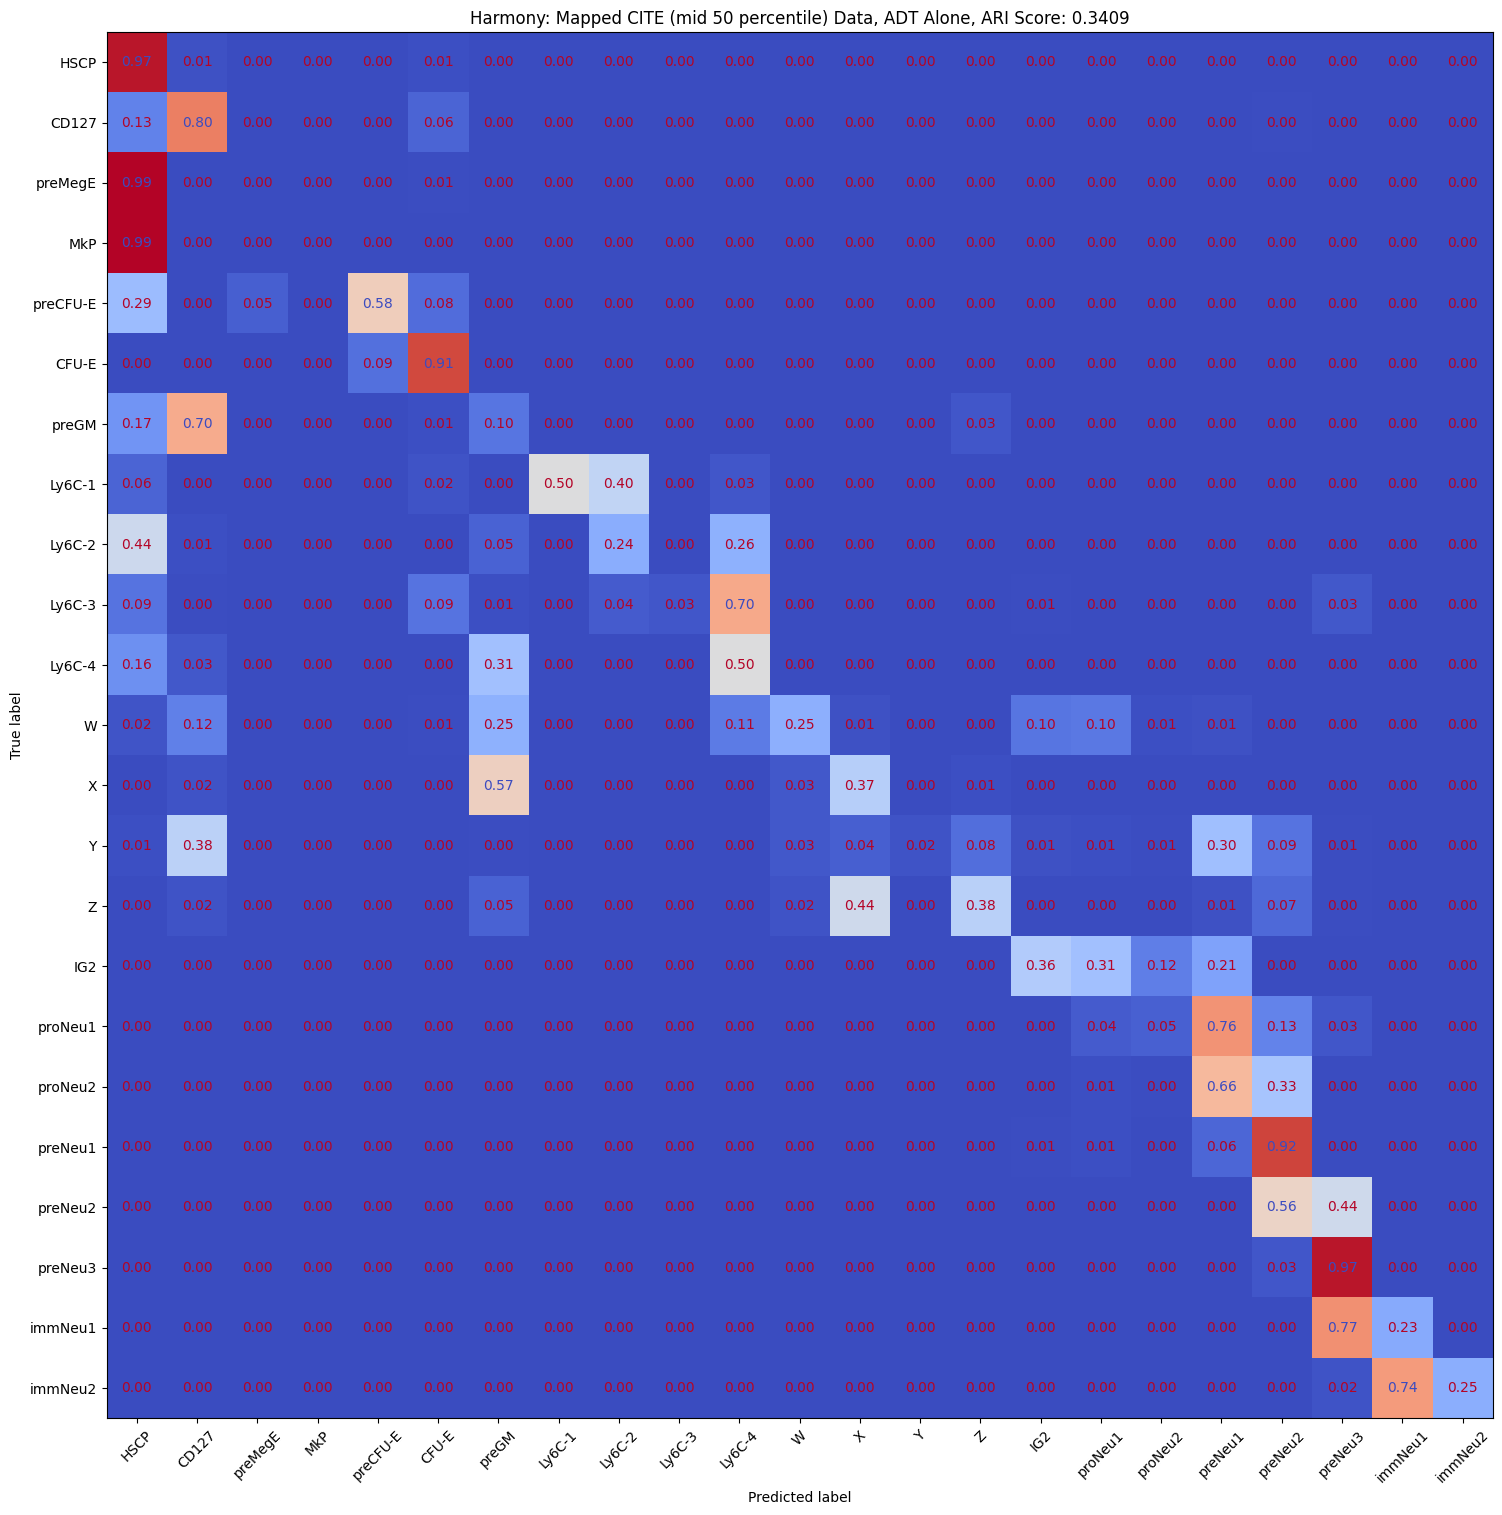

In [10]:
# Mapped CITE-seq ADT alone middle 50 percentile ADT cells
path_cite = "output/cite_inflow_integration_input/"\
    "middle_50_percentile_adt_umi_filtering/"\
    "mapped_cite_ari_adt_alone_middle_50_percentile.fea"
path_flow = "output/cite_inflow_integration_input/gated_inflow_inputs/"\
    "inflow_gated_1k_each_ari_groups_adt_alone.fea"

# Read in the data
cite = pd.read_feather(path_cite).rename({"final": "index"}, axis=1).set_index("index")
flow = pd.read_feather(path_flow)

# Read the annotation
cite_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "middle_50_percentile_adt_umi_filtering/"\
    "cell_anno_cite_ari_middle_50_percentile_adt_umi.csv")
flow_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "gated_inflow_inputs/inflow_gated_1k_each_ari_groups_adt_alone_groups.csv", 
    header=None)

# Set up the annotation to fig class input
tmp_anno_1 = cite_anno[["cell", "ari_group"]]
tmp_anno_1.columns = ["cell", "group"]
tmp_anno_2 = flow_anno
tmp_anno_2.columns = ["cell", "group"]

# Make Harmony tester object
mapped_cite_adt_alone_mid50 = harmony_knn_tester(\
    df1=cite,
    df2=flow[cite.columns.values],
    anno1=tmp_anno_1,
    anno2=tmp_anno_2,
    exp_name="Harmony: Mapped CITE (mid 50 percentile) Data, ADT Alone",
    groups_order=order_ari_groups.index.values)

# Run steps of harmony integration
mapped_cite_adt_alone_mid50.run_pca()
mapped_cite_adt_alone_mid50.run_harmony()
mapped_cite_adt_alone_mid50.knn_label_transfer()
mapped_cite_adt_alone_mid50.obtain_classification_metrics()
mapped_cite_adt_alone_mid50.plot_confusion_matrix(\
    path_save_fig="output/harmony_1k_per_gate_tests/"\
        "harmony_mapped_cite_mid50_adt_alone_conf_mat.png")

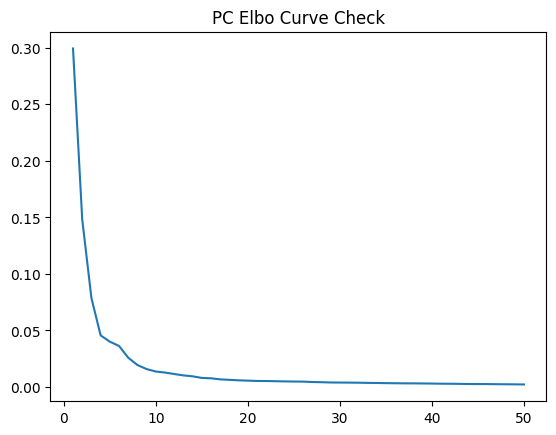

2023-01-28 20:53:27,864 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Starting harmony...


2023-01-28 20:53:32,950 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-01-28 20:53:33,185 - harmonypy - INFO - Iteration 1 of 10
2023-01-28 20:53:48,526 - harmonypy - INFO - Iteration 2 of 10
2023-01-28 20:54:04,028 - harmonypy - INFO - Converged after 2 iterations


Harmony Done!
Starting KNN-label transfer...
KNN-label transfer done!


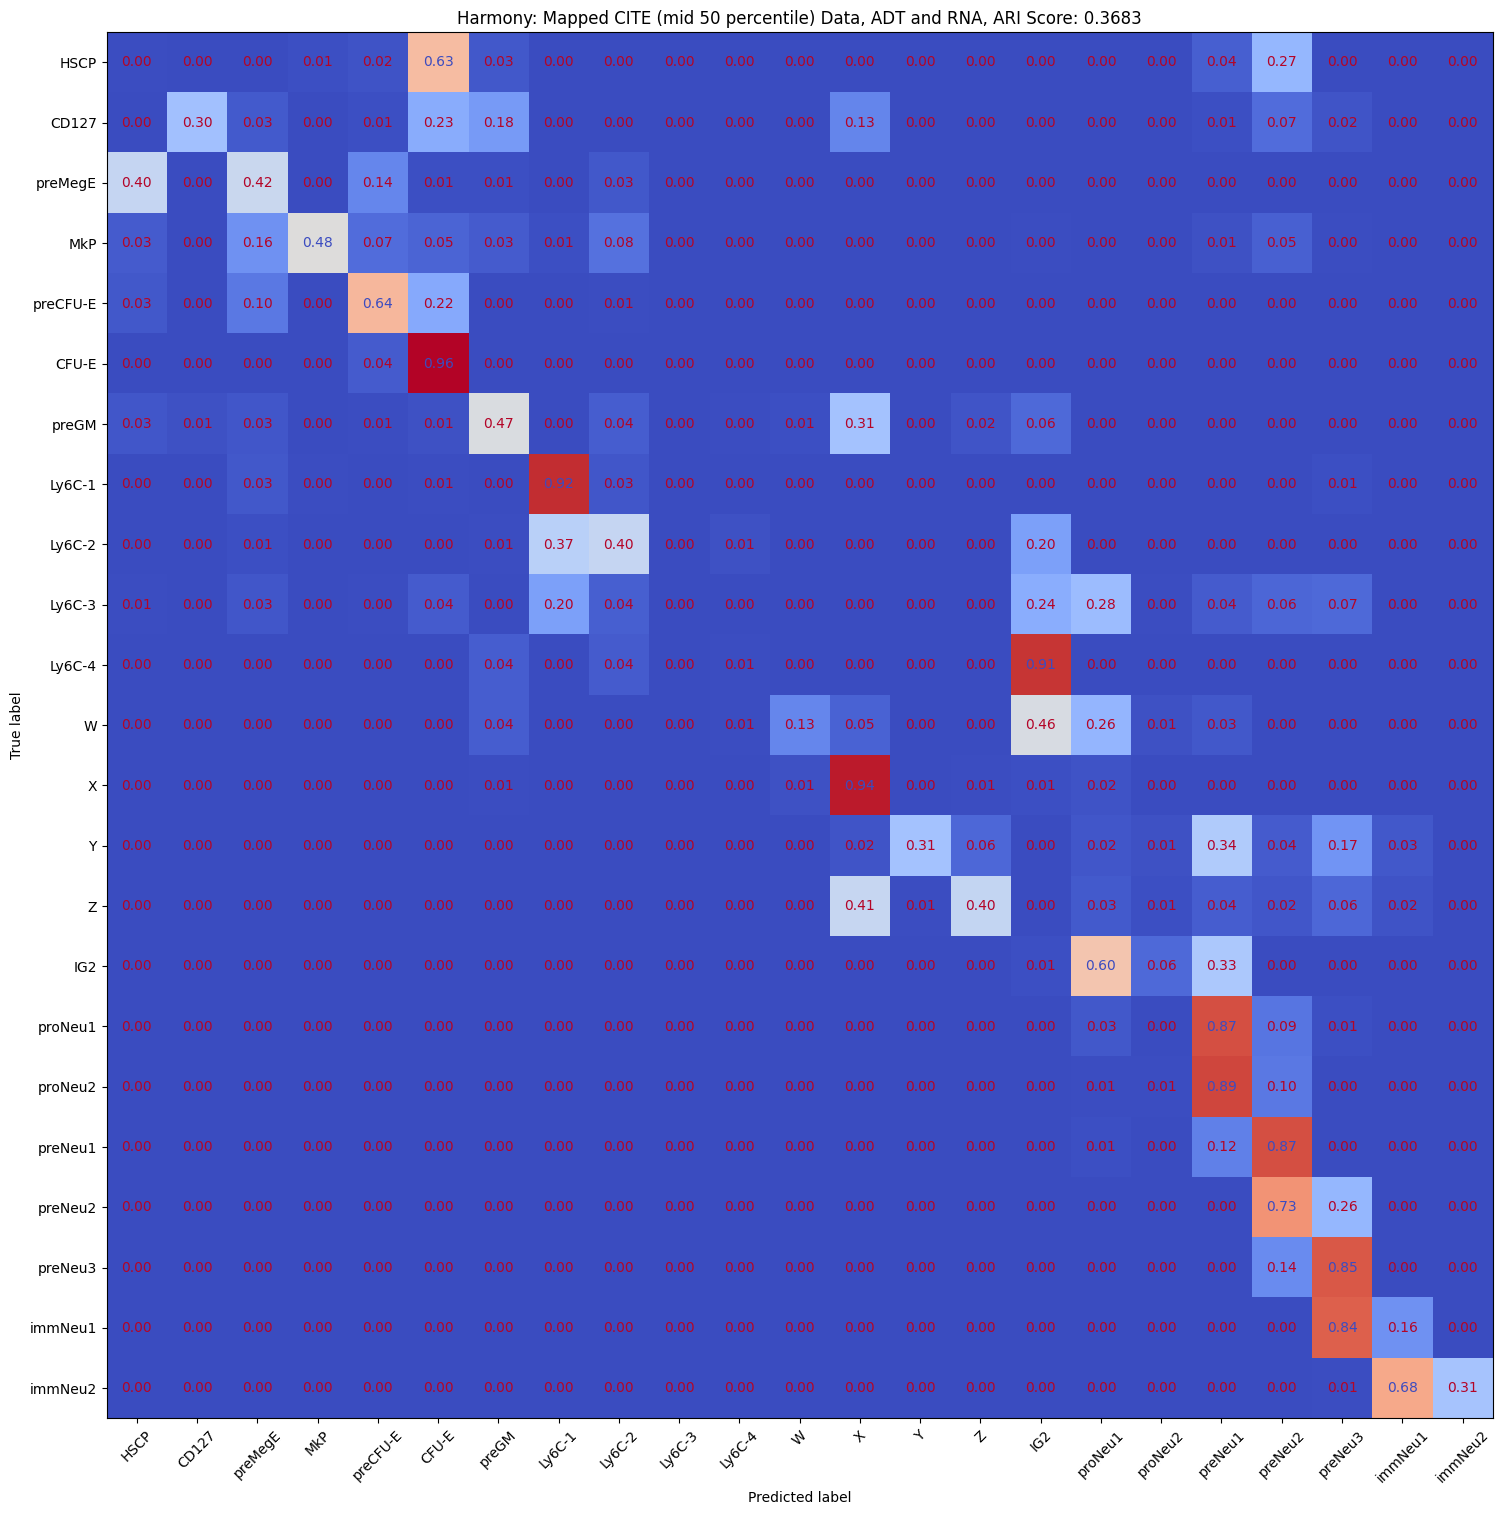

In [11]:
# Mapped CITE-seq ADT and RNA middle 50 percentile ADT cells
path_cite = "output/cite_inflow_integration_input/"\
    "middle_50_percentile_adt_umi_filtering/"\
    "mapped_cite_ari_adt_rna_middle_50_percentile.fea"
path_flow = "output/cite_inflow_integration_input/gated_inflow_inputs/"\
    "inflow_gated_1k_each_ari_groups_adt_rna.fea"

# Read in the data
cite = pd.read_feather(path_cite).rename({"final": "index"}, axis=1).set_index("index")
flow = pd.read_feather(path_flow)

# Read the annotation
cite_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "middle_50_percentile_adt_umi_filtering/"\
    "cell_anno_cite_ari_middle_50_percentile_adt_umi.csv")
flow_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "gated_inflow_inputs/inflow_gated_1k_each_ari_groups_adt_alone_groups.csv", 
    header=None)

# Set up the annotation to fig class input
tmp_anno_1 = cite_anno[["cell", "ari_group"]]
tmp_anno_1.columns = ["cell", "group"]
tmp_anno_2 = flow_anno
tmp_anno_2.columns = ["cell", "group"]

# Make Harmony tester object
mapped_cite_adt_rna_mid50 = harmony_knn_tester(\
    df1=cite,
    df2=flow[cite.columns.values],
    anno1=tmp_anno_1,
    anno2=tmp_anno_2,
    exp_name="Harmony: Mapped CITE (mid 50 percentile) Data, ADT and RNA",
    groups_order=order_ari_groups.index.values)

# Run steps of harmony integration
mapped_cite_adt_rna_mid50.run_pca()
mapped_cite_adt_rna_mid50.run_harmony()
mapped_cite_adt_rna_mid50.knn_label_transfer()
mapped_cite_adt_rna_mid50.obtain_classification_metrics()
mapped_cite_adt_rna_mid50.plot_confusion_matrix(\
    path_save_fig="output/harmony_1k_per_gate_tests/"\
        "harmony_mapped_cite_mid50_adt_rna_conf_mat.png")

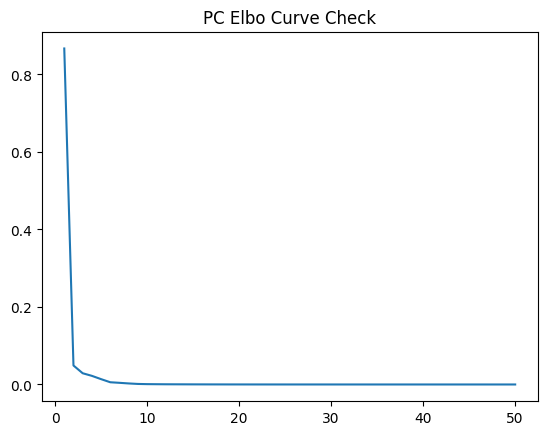

2023-01-28 20:54:08,007 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Starting harmony...


2023-01-28 20:54:12,587 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-01-28 20:54:12,785 - harmonypy - INFO - Iteration 1 of 10
2023-01-28 20:54:27,135 - harmonypy - INFO - Iteration 2 of 10
2023-01-28 20:54:36,316 - harmonypy - INFO - Iteration 3 of 10
2023-01-28 20:54:40,528 - harmonypy - INFO - Converged after 3 iterations


Harmony Done!
Starting KNN-label transfer...
KNN-label transfer done!


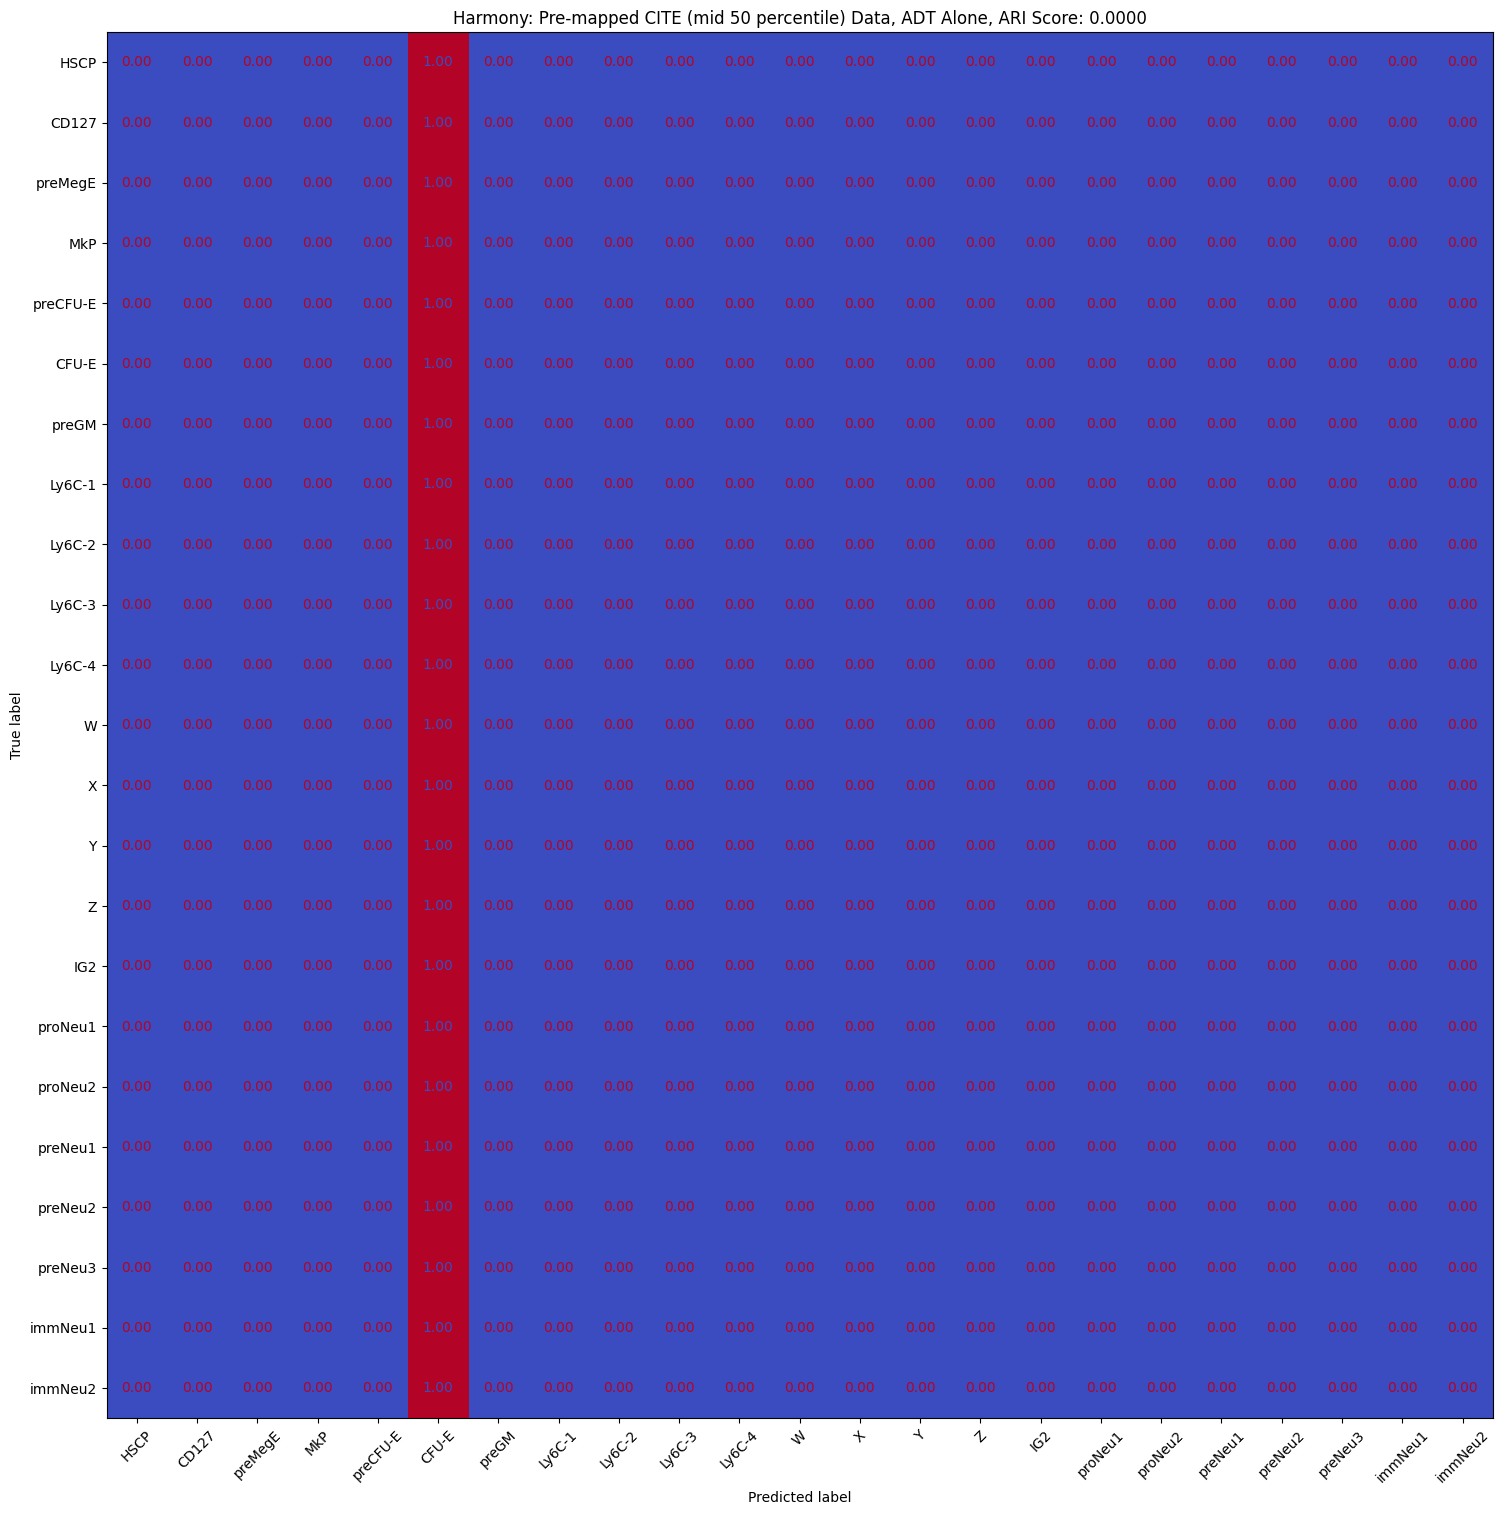

In [12]:
# Pre-mapped CITE-seq ADT alone middle 50 percentile ADT cells
path_cite = "output/cite_inflow_integration_input/"\
    "middle_50_percentile_adt_umi_filtering/"\
    "pre_mapped_cite_ari_adt_alone_middle_50_percentile.fea"
path_flow = "output/cite_inflow_integration_input/gated_inflow_inputs/"\
    "inflow_gated_1k_each_ari_groups_adt_alone.fea"

# Read in the data
cite = pd.read_feather(path_cite).rename({"final": "index"}, axis=1).set_index("index")
flow = pd.read_feather(path_flow)

# Read the annotation
cite_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "middle_50_percentile_adt_umi_filtering/"\
    "cell_anno_cite_ari_middle_50_percentile_adt_umi.csv")
flow_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "gated_inflow_inputs/inflow_gated_1k_each_ari_groups_adt_alone_groups.csv", 
    header=None)

# Set up the annotation to fig class input
tmp_anno_1 = cite_anno[["cell", "ari_group"]]
tmp_anno_1.columns = ["cell", "group"]
tmp_anno_2 = flow_anno
tmp_anno_2.columns = ["cell", "group"]

# Make Harmony tester object
pre_mapped_cite_adt_alone_mid50 = harmony_knn_tester(\
    df1=cite,
    df2=flow[cite.columns.values],
    anno1=tmp_anno_1,
    anno2=tmp_anno_2,
    exp_name="Harmony: Pre-mapped CITE (mid 50 percentile) Data, ADT Alone",
    groups_order=order_ari_groups.index.values)

# Run steps of harmony integration
pre_mapped_cite_adt_alone_mid50.run_pca()
pre_mapped_cite_adt_alone_mid50.run_harmony()
pre_mapped_cite_adt_alone_mid50.knn_label_transfer()
pre_mapped_cite_adt_alone_mid50.obtain_classification_metrics()
pre_mapped_cite_adt_alone_mid50.plot_confusion_matrix(\
    path_save_fig="output/harmony_1k_per_gate_tests/"\
        "harmony_pre_mapped_cite_mid50_adt_alone_conf_mat.png")

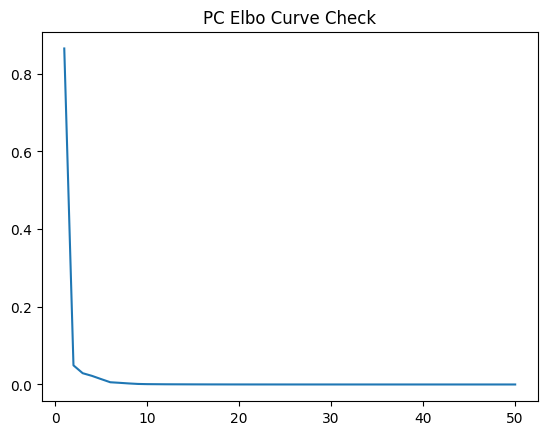

2023-01-28 20:54:44,658 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Starting harmony...


2023-01-28 20:54:49,597 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-01-28 20:54:49,818 - harmonypy - INFO - Iteration 1 of 10
2023-01-28 20:55:03,952 - harmonypy - INFO - Iteration 2 of 10
2023-01-28 20:55:08,031 - harmonypy - INFO - Converged after 2 iterations


Harmony Done!
Starting KNN-label transfer...
KNN-label transfer done!


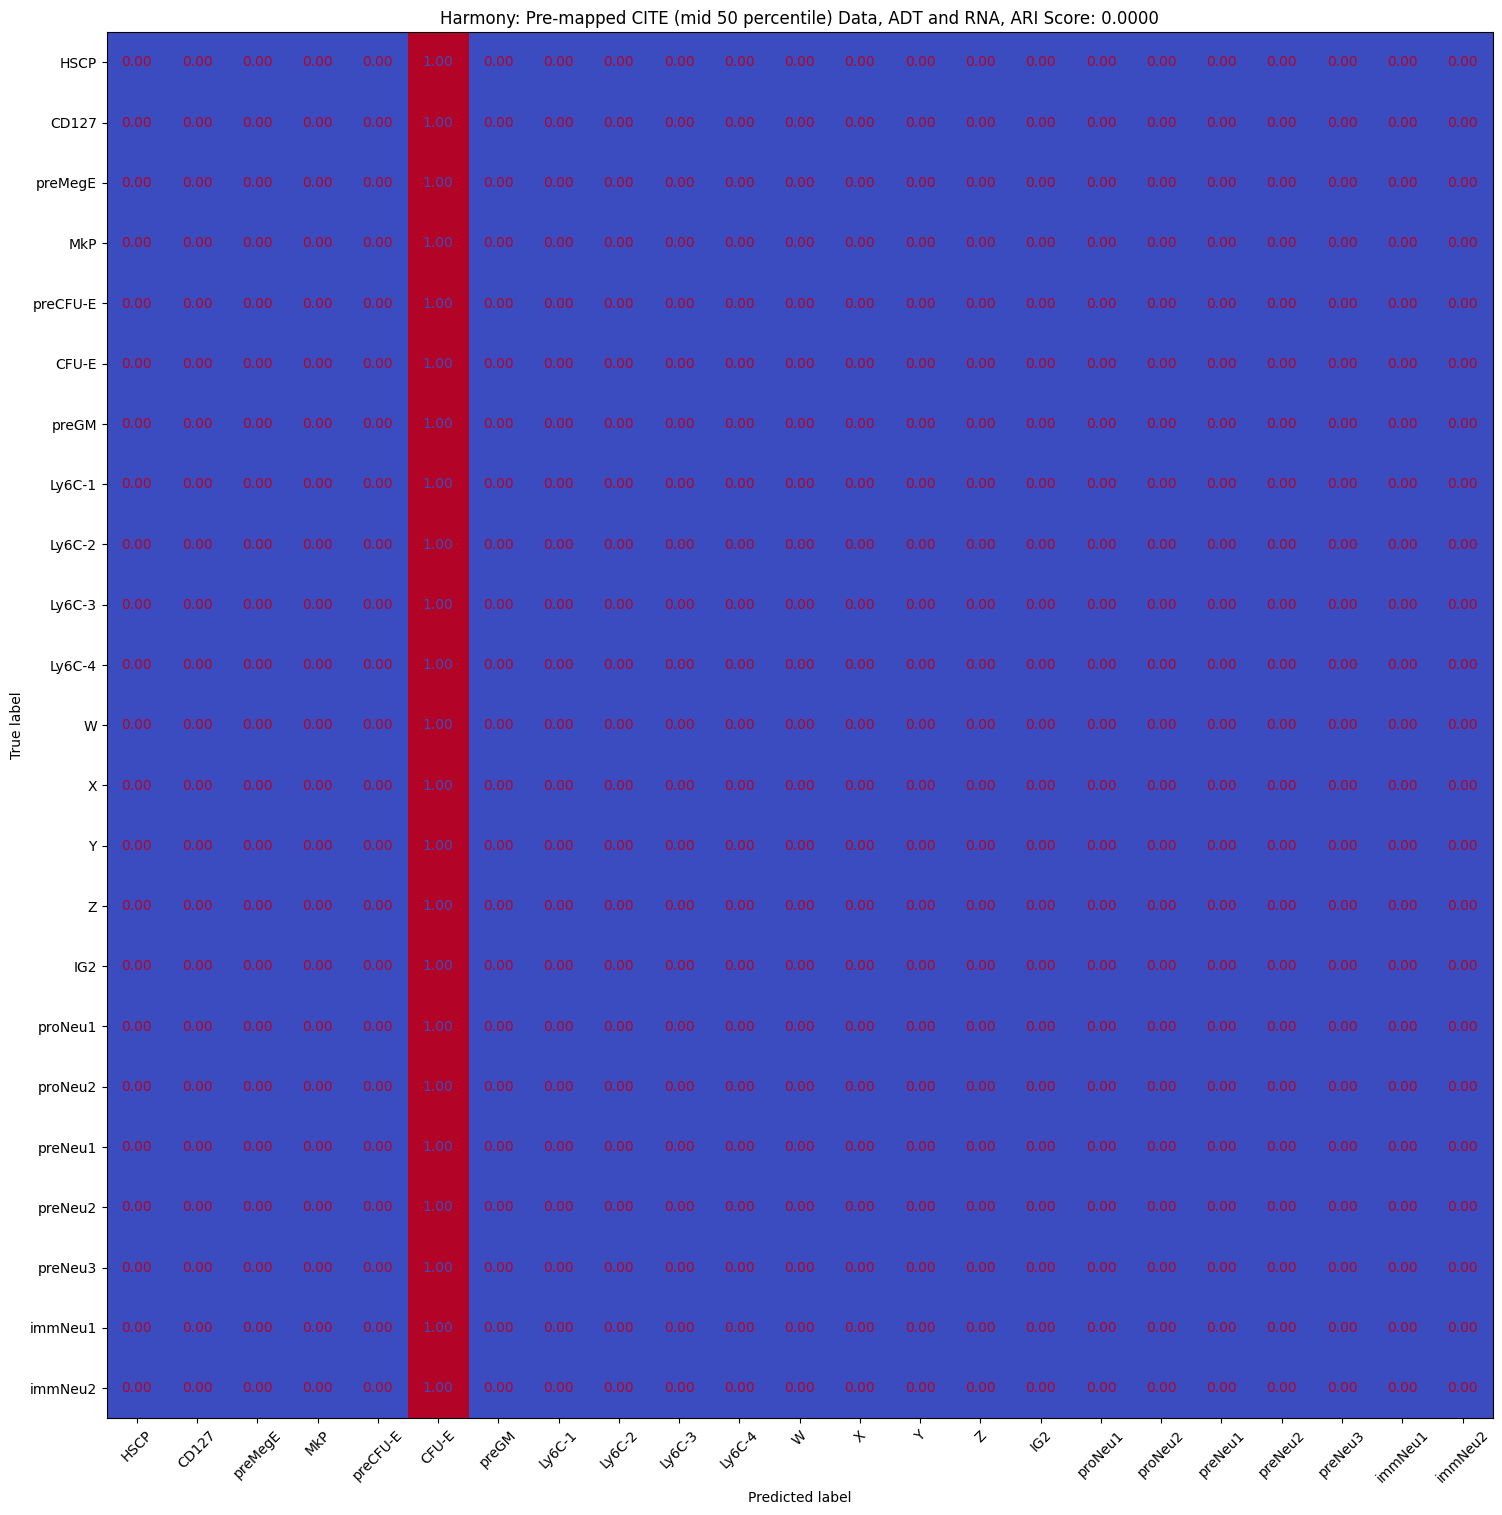

In [13]:
# Pre-mapped CITE-seq ADT and RNA middle 50 percentile ADT cells
path_cite = "output/cite_inflow_integration_input/"\
    "middle_50_percentile_adt_umi_filtering/"\
    "pre_mapped_cite_ari_adt_rna_middle_50_percentile.fea"
path_flow = "output/cite_inflow_integration_input/gated_inflow_inputs/"\
    "inflow_gated_1k_each_ari_groups_adt_rna.fea"

# Read in the data
cite = pd.read_feather(path_cite).rename({"final": "index"}, axis=1).set_index("index")
flow = pd.read_feather(path_flow)

# Read the annotation
cite_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "middle_50_percentile_adt_umi_filtering/"\
    "cell_anno_cite_ari_middle_50_percentile_adt_umi.csv")
flow_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "gated_inflow_inputs/inflow_gated_1k_each_ari_groups_adt_alone_groups.csv", 
    header=None)

# Set up the annotation to fig class input
tmp_anno_1 = cite_anno[["cell", "ari_group"]]
tmp_anno_1.columns = ["cell", "group"]
tmp_anno_2 = flow_anno
tmp_anno_2.columns = ["cell", "group"]

# Make Harmony tester object
pre_mapped_cite_adt_rna_mid50 = harmony_knn_tester(\
    df1=cite,
    df2=flow[cite.columns.values],
    anno1=tmp_anno_1,
    anno2=tmp_anno_2,
    exp_name="Harmony: Pre-mapped CITE (mid 50 percentile) Data, ADT and RNA",
    groups_order=order_ari_groups.index.values)

# Run steps of harmony integration
pre_mapped_cite_adt_rna_mid50.run_pca()
pre_mapped_cite_adt_rna_mid50.run_harmony()
pre_mapped_cite_adt_rna_mid50.knn_label_transfer()
pre_mapped_cite_adt_rna_mid50.obtain_classification_metrics()
pre_mapped_cite_adt_rna_mid50.plot_confusion_matrix(\
    path_save_fig="output/harmony_1k_per_gate_tests/"\
        "harmony_pre_mapped_cite_mid50_adt_rna_conf_mat.png")

In [ ]:
# cite_anno = pd.read_csv("output/cite_inflow_integration_input/without_adt_umi_filtering/cell_anno_cite_ari_all_cells.csv")
# flow_anno = pd.read_csv("output/cite_inflow_integration_input/gated_inflow_inputs/inflow_gated_1k_each_ari_groups_adt_alone_groups.csv", header=None)
# cite_anno

# combined_groups = pd.DataFrame(\
#     np.concatenate([\
#         cite_anno[["cell", "ari_group"]].values,
#         flow_anno.values]))

# combined_groups["assay"] = (["cite"] * cite_anno.shape[0]) + \
#     (["flow"] * flow_anno.shape[0])

# combined_groups.columns = ["cell", "ari_group", "assay"]

# combined_groups

,cell,ari_group,assay
0,GACGCTGGTACCTGTA-1.AS_CITE_HSC,HSCP,cite
1,AACCCAAAGGTAGACC-1.AS_CITE_HSC,HSCP,cite
2,CGACAGCCACGCAGTC-1.AS_CITE_HSC,HSCP,cite
3,TGCGGCAAGGCTGTAG-1.AS_CITE_HSC,HSCP,cite
4,TTGTTTGTCCGTGGTG-1.AS_CITE_HSC,HSCP,cite
...,...,...,...
45833,22995,Z,flow
45834,22996,Z,flow
45835,22997,Z,flow
45836,22998,Z,flow


In [ ]:
# combined = pd.DataFrame(\
#     np.concatenate([\
#         cite.values,
#         flow[cite.columns.values].values], axis=0),
#     columns=cite.columns.values)

# combined

,ADT_Link-0:CCR3_CD193:CD193,ADT_Link-1:CD102:CD102,ADT_Link-2:CD105:BUV805-A,ADT_Link-3:CD106:PerCP-Cy5.5-A,ADT_Link-4:CD107a_LAMP_1:CD107a,ADT_Link-5:CD117_c_kit:BV650-A,ADT_Link-6:CD11a:CD11a,ADT_Link-7:CD11c:CD11c,ADT_Link-8:CD127:BV785-A,ADT_Link-9:CD135:PE-Cy5-A,...,ADT_Link-97:anti_human_mouse_CD49f:CD49f,ADT_Link-98:anti_human_mouse_integrin_7:BUV615-A,ADT_Link-99:anti_mouse_human_CD11b:BV750-A,ADT_Link-100:anti_mouse_human_CD44:CD44,ADT_Link-102:anti_mouse_rat_CD29:CD29,ADT_Link-103:anti_mouse_rat_CD61:CD61,ADT_Link-104:anti_mouse_rat_CD81:CD81,ADT_Link-105:anti_mouse_rat_human_CD27:BUV737-A,ADT_Link-203:CD49d:LPAM1,ADT_Link-204:anti_human_mouse_integrin_7:LPAM1
0,0.109053,0.291741,0.094863,0.404280,0.298199,0.176327,0.368332,0.223758,0.271628,0.162636,...,0.442887,0.107392,0.153413,0.508200,0.440553,0.199158,0.499944,0.731139,0.044956,0.135195
1,0.128139,0.214157,0.109731,0.409287,0.322791,0.149756,0.259854,0.224522,0.256019,0.176585,...,0.308497,0.099949,0.118945,0.407444,0.212036,0.151391,0.424361,0.529137,0.037117,0.114518
2,0.143296,0.232997,0.122120,0.420214,0.177241,0.181558,0.268982,0.225052,0.340398,0.174360,...,0.381414,0.102328,0.139500,0.345777,0.302912,0.212069,0.460541,0.434687,0.042773,0.120808
3,0.123056,0.212693,0.107196,0.409320,0.285386,0.147816,0.276562,0.223849,0.298795,0.171461,...,0.283883,0.116601,0.123034,0.319057,0.217880,0.170351,0.404469,0.416065,0.036406,0.162222
4,0.083344,0.213089,0.068175,0.395780,0.395171,0.105887,0.308653,0.222661,0.152590,0.123011,...,0.312402,0.112037,0.163248,0.373460,0.251743,0.198909,0.500328,0.272224,0.031137,0.148246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45833,0.189041,0.289602,0.184403,0.514486,0.735872,0.650225,0.792088,0.000000,0.431983,0.243987,...,0.688480,0.098522,0.461700,0.813754,0.729366,0.625521,0.645071,0.371043,0.263834,0.263834
45834,0.314050,0.378531,0.050138,0.499773,0.567661,0.338856,0.724096,0.000000,0.114437,0.636920,...,0.300764,0.240772,0.388836,0.554774,0.742472,0.570975,0.526477,0.315195,0.373834,0.373834
45835,0.276962,0.188551,0.147461,0.456746,0.767974,0.415497,0.794128,0.000000,0.308423,0.200341,...,0.598248,0.115807,0.446083,0.805675,0.666923,0.672564,0.428019,0.284667,0.217871,0.217871
45836,0.304597,0.268868,0.032629,0.460545,0.572006,0.394466,0.731719,0.000000,0.208117,0.693940,...,0.331472,0.331391,0.492585,0.666259,0.715936,0.605882,0.562786,0.296745,0.455626,0.455626


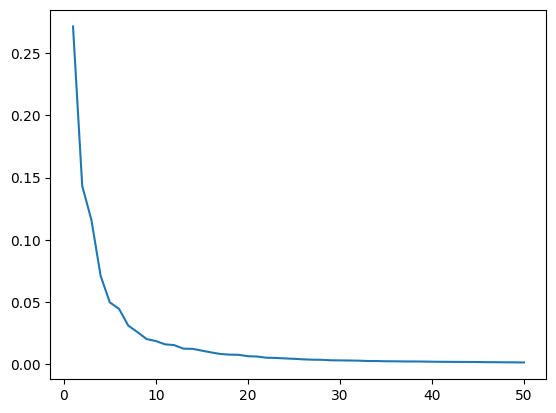

In [ ]:
# pca_model = PCA(n_components=50)
# combined_pca = pca_model.fit_transform(combined.values)


# plt.plot(\
#     list(range(1,pca_model.explained_variance_ratio_.shape[0]+1)),
#     pca_model.explained_variance_ratio_)


In [ ]:
# ho = hm.run_harmony(\
#     combined_pca[:,:20], 
#     combined_groups, 
#     ["assay"])

2023-01-28 02:02:16,695 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-01-28 02:02:25,665 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-01-28 02:02:25,987 - harmonypy - INFO - Iteration 1 of 10
2023-01-28 02:02:51,838 - harmonypy - INFO - Iteration 2 of 10
2023-01-28 02:03:15,337 - harmonypy - INFO - Iteration 3 of 10
2023-01-28 02:03:37,687 - harmonypy - INFO - Iteration 4 of 10
2023-01-28 02:03:59,219 - harmonypy - INFO - Iteration 5 of 10
2023-01-28 02:04:21,866 - harmonypy - INFO - Iteration 6 of 10
2023-01-28 02:04:44,419 - harmonypy - INFO - Iteration 7 of 10
2023-01-28 02:05:07,888 - harmonypy - INFO - Iteration 8 of 10
2023-01-28 02:05:30,520 - harmonypy - INFO - Iteration 9 of 10
2023-01-28 02:05:51,825 - harmonypy - INFO - Iteration 10 of 10
2023-01-28 02:06:13,646 - harmonypy - INFO - Stopped before convergence


In [ ]:
# hpc = pd.DataFrame(ho.Z_corr.T, index=combined_groups.index.values)
# hpc_cite = hpc.loc[\
#     combined_groups.loc[combined_groups["assay"] == "cite"].index.values].copy()
# hpc_flow = hpc.loc[\
#     combined_groups.loc[combined_groups["assay"] == "flow"].index.values].copy()
# hpc_flow

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
22838,-0.358337,0.311825,0.765572,-0.038283,-0.052658,0.097024,0.071532,0.473280,0.028171,-0.161659,0.063987,-0.013453,-0.112080,0.009794,0.134910,-0.193194,0.303304,0.169315,-0.291024,0.223533
22839,-0.582567,-0.283113,0.239217,-0.670944,0.023765,0.181609,0.049770,0.224619,0.060443,0.055377,-0.164821,-0.157985,-0.292536,0.099817,0.219901,-0.000273,0.105771,-0.005790,0.255094,-0.068517
22840,-0.587895,-0.737160,0.118027,-0.709579,-0.346591,0.292293,-0.010641,0.154609,0.069627,-0.001974,-0.229986,-0.131318,-0.266427,0.118527,0.037328,-0.023582,-0.031822,-0.016444,0.137511,-0.005952
22841,-0.603555,0.591872,0.376578,-0.634959,0.060519,-0.029912,-0.163100,0.333777,0.037767,-0.243026,-0.144919,-0.324974,-0.198489,0.062944,0.247147,-0.137781,0.150504,0.129050,0.066335,-0.006074
22842,-0.543709,0.249894,0.362026,-0.565233,-0.014031,0.102373,-0.088083,0.270889,0.000715,-0.246807,-0.068113,-0.254559,-0.178201,-0.009142,0.155336,-0.176814,0.156240,0.089930,-0.077758,0.090171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45833,0.423893,0.584366,-0.824012,-0.213972,0.052615,0.312623,0.024063,-0.178755,0.042866,0.090105,-0.053388,0.088574,0.056140,0.010174,-0.022799,-0.021125,0.017456,0.136474,0.071463,-0.095052
45834,-0.183678,0.078011,0.243126,-0.095644,-0.572698,0.295367,-0.483702,0.247036,-0.071683,-0.247410,0.012910,0.040116,0.013544,0.140279,-0.187078,0.186410,-0.154950,0.075092,0.145484,0.005100
45835,0.220796,0.113690,-0.564232,-0.351198,-0.299098,0.297842,-0.003781,-0.149379,-0.072068,0.223589,-0.032827,0.073310,0.119353,-0.019784,-0.198923,0.021302,0.169477,0.015796,0.058290,-0.023150
45836,-0.086251,0.361828,0.264558,0.032391,-0.649897,0.323138,-0.587962,0.305024,-0.109110,-0.251012,-0.028288,0.119226,0.124118,0.248171,-0.156366,0.243956,-0.158715,-0.083311,0.253831,0.047521


In [ ]:
# le = LabelEncoder().fit(\
#     combined_groups.loc[combined_groups["assay"] == "cite", "ari_group"].values)
# knn_Y_train_encoded = le.transform(\
#     combined_groups.loc[combined_groups["assay"] == "cite", "ari_group"].values)
# model = KNeighborsClassifier(n_neighbors=15,weights='distance')
# model.fit(hpc_cite.values,knn_Y_train_encoded)
# knn_Y_test = le.inverse_transform(model.predict(hpc_flow.values))

# knn_Y_test

array(['CD127', 'CD127', 'CD127', ..., 'X', 'Z', 'HSCP'], dtype=object)

In [ ]:
# tmp_ari_score = adjusted_rand_score(\
#     combined_groups.loc[combined_groups["assay"] == "flow", "ari_group"].values,
#     knn_Y_test)

/home/kyle/anaconda3/envs/pyInfinityFlow/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/home/kyle/anaconda3/envs/pyInfinityFlow/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


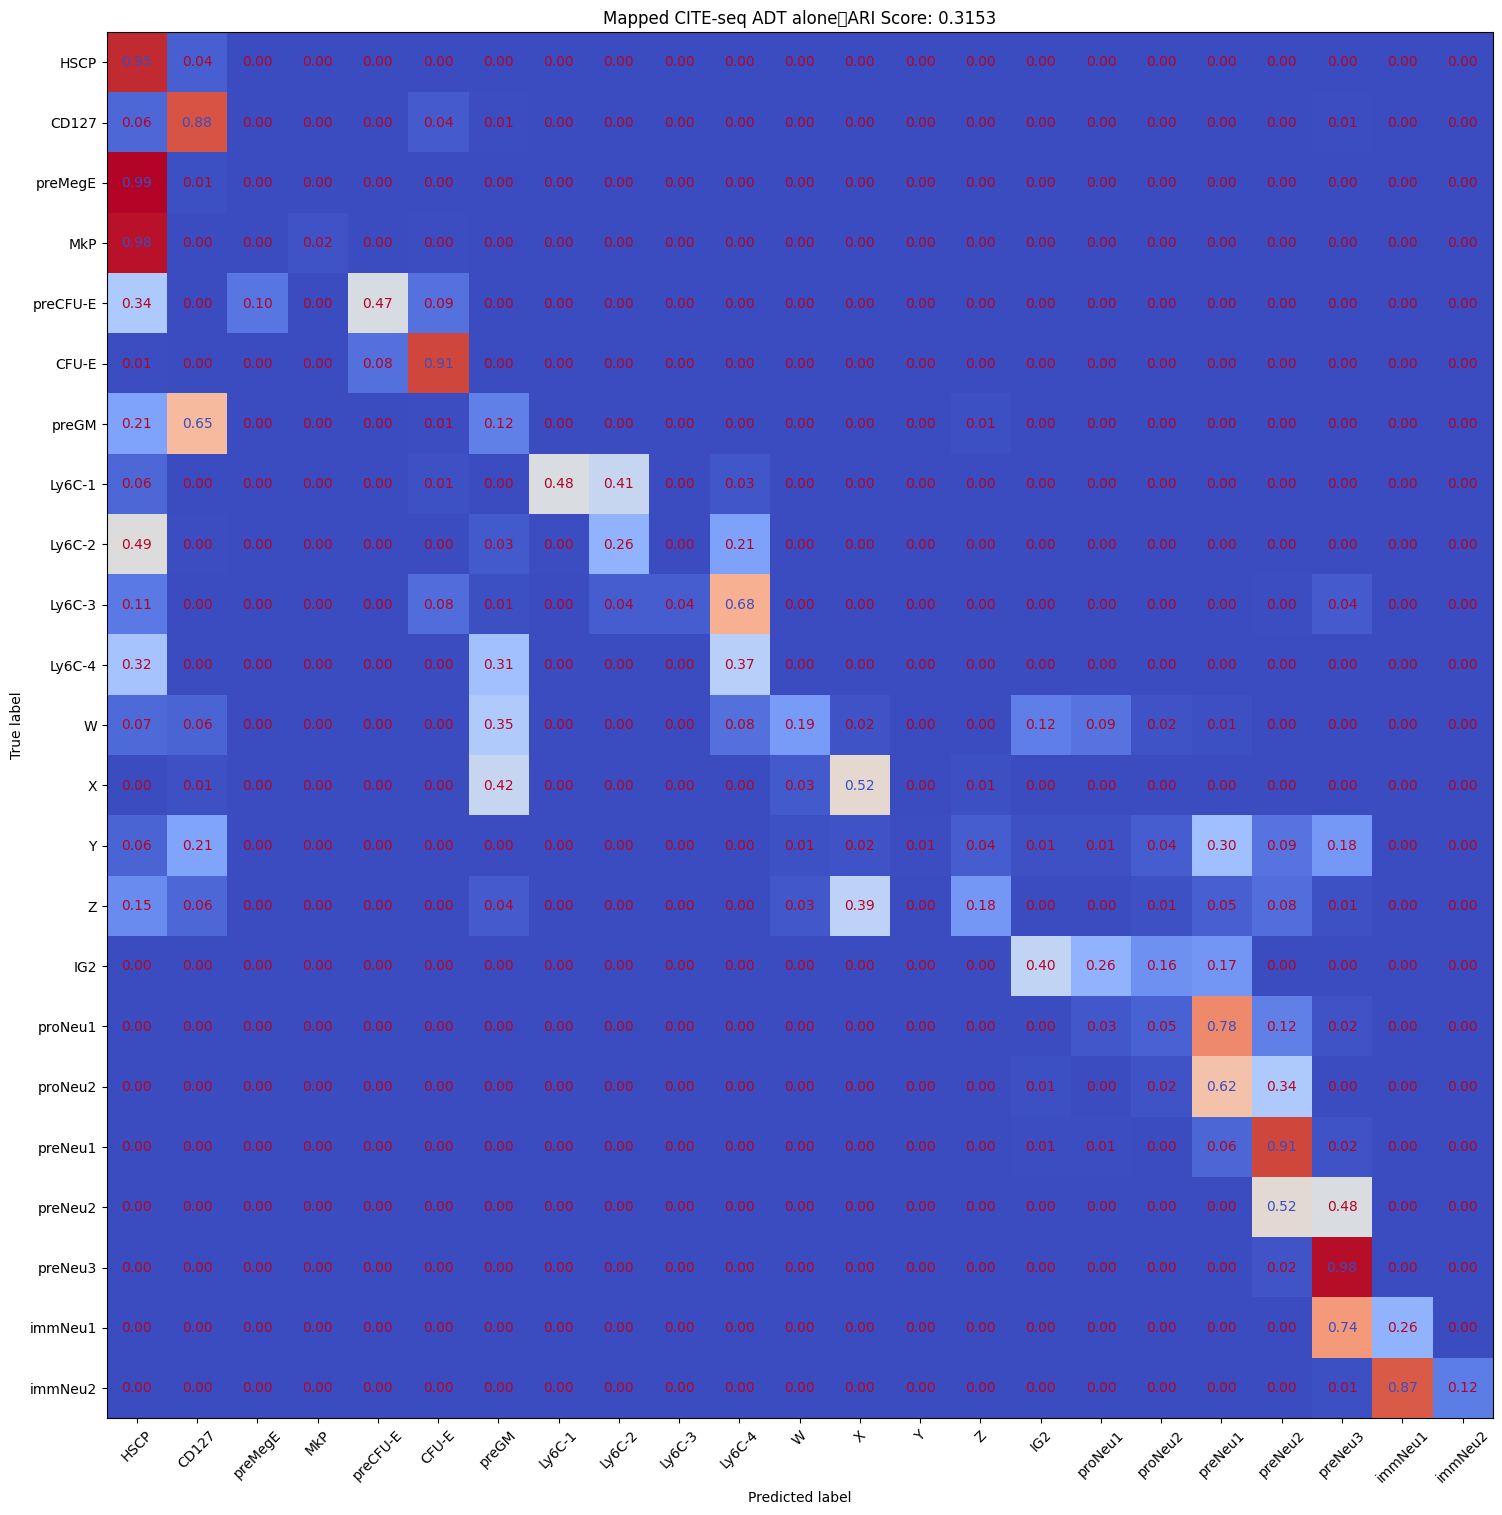

In [ ]:
# fig, ax = plt.subplots(figsize=(18,18))

# ax.set_title("{}, ARI Score: {:.4f}".format("Mapped CITE-seq ADT alone", tmp_ari_score))

# ConfusionMatrixDisplay.from_predictions(\
#     y_true=combined_groups.loc[combined_groups["assay"] == "flow", "ari_group"].values,
#     y_pred=knn_Y_test,
#     labels=order_ari_groups.index.values,
#     xticks_rotation=45,
#     ax=ax,
#     cmap="coolwarm",
#     normalize="true",
#     values_format=".2f",
#     colorbar=False)